This file creates two trainable models. One is responsible for filtering raw data from the MCG datasets created containing simulated measurements of the reflected MW signal the NV magnetometer measures for time series samples containing heartbeats and blank samples. This model is trained with a correlation based loss and aims to filter the raw samples such that they look like the original pre-processed MCG samples, which are trivial to classify. The second model is trained to classify samples as containing a heartbeat or not, for heartbeat detection, and makes use fo the trained filtration model within it.

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 75.4 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import decimate, find_peaks
import matplotlib.pyplot as plt
import wfdb
import os
from sklearn.preprocessing import StandardScaler

In [ ]:

# Assumed constants and parameters (example values)
g_e = 2.00231930436256  # Electron g-factor
mu_B = 9.274009994e-24  # Bohr magneton (J/T)
h = 6.626e-34           # Planck constant (J·s)
base_frequency = 2.87e9 # Hz
gamma_true = 55e3       # Example gamma
gs_true = 0.019         # Example gs
k = 260e3
kc1 = 130e3
gammao = 2.23e3
Gamma = 330e3
Polarization = 0.1 # Just a placeholder, use correct values from your code
N = 1e18           # Placeholder, use from your code

def simulate_r2_numpy_vectorized(frequency, spin_freq, gamma, gs):
    # This function computes the reflected MW signal measured based on measurement frequency and true spin transition frequency
    # This is also dependent on system parameter estimates, which for now are limited to gamma (homogeneous linewidth) and gs (single coupling strength)
    h_np = 6.626e-34
    energy_d = h_np * frequency
    Delta = spin_freq - frequency
    g = np.sqrt(N * Polarization) * gs * 0.16
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1
    chi_0 = np.sqrt(1 + 8*(gamma/gammao)*(gs**2)*alpha2/(gamma**2))
    Gamma_1_0 = Gamma + chi_0*gamma
    geff_0 = g/chi_0
    denom = (Delta - (g**2)*Delta/((Gamma_1_0/2)**2+Delta**2))**2 + \
            (k/2 + (geff_0**2)*(Gamma_1_0/2)/((Gamma_1_0/2)**2+Delta**2))**2
    term1 = kc1 * beta2
    alpha2_1 = term1/denom
    r2 = (-1 + np.sqrt(kc1 * alpha2_1 / beta2 + 1e-12))**2
    return r2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.fft
from scipy.signal import firwin
import torch.optim as optim

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.signal import decimate # Keep for potential use elsewhere, but not for pre-simulation processing
import random # For plotting random examples

# can use MCG dataset creation file to recreate
data_folder = '/content/drive/My Drive/MIT/MEng/MCG_data/subject1' # Make sure this path is correct

# Load the raw datasets (ensure these are the original, dense versions)
heartbeat_raw = np.load(os.path.join(data_folder, 'subject1_heartbeat_dataset_raw.npy'))
non_heartbeat_raw = np.load(os.path.join(data_folder, 'subject1_non_heartbeat_dataset_raw.npy'))

# Optional: Load processed data for initial comparison plots or filter training targets
heartbeat_processed = np.load(os.path.join(data_folder, 'subject1_heartbeat_dataset_processed.npy'))
non_heartbeat_processed = np.load(os.path.join(data_folder, 'subject1_non_heartbeat_dataset_processed.npy'))

print("--- Initial Data Shapes ---")
print("Heartbeat dataset raw shape:", heartbeat_raw.shape)
print("Non-heartbeat dataset raw shape:", non_heartbeat_raw.shape)
if 'heartbeat_processed' in locals():
    print("Heartbeat dataset processed shape:", heartbeat_processed.shape)
    print("Non-heartbeat dataset processed shape:", non_heartbeat_processed.shape)

# Store original raw window size for reference
num_trials, beats_per_trial, dense_raw_window_size = heartbeat_raw.shape
print(f"Dense raw window size: {dense_raw_window_size}")
if 'proc_window_size' in locals():
     print(f"Processed window size: {proc_window_size}")

--- Initial Data Shapes ---
Heartbeat dataset raw shape: (25, 40, 40960)
Non-heartbeat dataset raw shape: (25, 40, 40960)
Heartbeat dataset processed shape: (25, 40, 160)
Non-heartbeat dataset processed shape: (25, 40, 160)
Dense raw window size: 40960



--- Visualizing Example Raw vs Processed ---


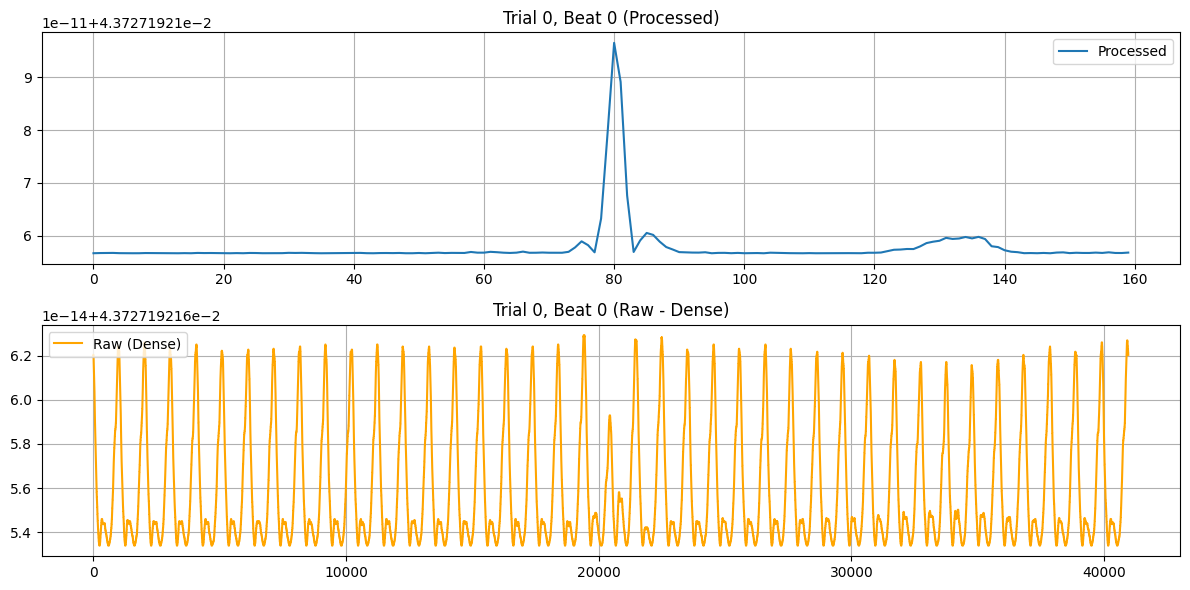

In [ ]:
# --- 2. Initial Visualization (Optional but Recommended) ---
# Keep your original plotting code here to visualize raw vs processed if needed
# Example: Plotting the first valid beat from the first trial
print("\n--- Visualizing Example Raw vs Processed ---")
trial_to_plot = 0
if 'heartbeat_processed' in locals():
    valid_beats = np.where(~np.all(heartbeat_processed[trial_to_plot] == 0, axis=1))[0]
    if len(valid_beats) > 0:
        beat_idx = valid_beats[0]
        proc_segment = heartbeat_processed[trial_to_plot, beat_idx, :]
        raw_segment = heartbeat_raw[trial_to_plot, beat_idx, :] # Dense raw

        plt.figure(figsize=(12, 6))
        plt.subplot(2,1,1)
        plt.plot(proc_segment, label='Processed')
        plt.title(f'Trial {trial_to_plot}, Beat {beat_idx} (Processed)')
        plt.legend()
        plt.grid(True)

        plt.subplot(2,1,2)
        plt.plot(raw_segment, label='Raw (Dense)', color='orange')
        plt.title(f'Trial {trial_to_plot}, Beat {beat_idx} (Raw - Dense)')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid processed heartbeats found in trial {trial_to_plot} to plot.")
else:
    print("Processed data not loaded, skipping raw vs processed plot.")



In [ ]:
from scipy.signal import decimate

# Reshape the dense raw data
heartbeats_flat_raw = heartbeat_raw.reshape(-1, heartbeat_raw.shape[-1])
non_heartbeats_flat_raw = non_heartbeat_raw.reshape(-1, non_heartbeat_raw.shape[-1])

# Create labels based on the raw data shapes
heartbeat_labels = np.ones((heartbeats_flat_raw.shape[0],), dtype=np.int64)
non_heartbeat_labels = np.zeros((non_heartbeats_flat_raw.shape[0],), dtype=np.int64)

# Concatenate dense raw data
X_raw_dense_combined = np.concatenate([heartbeats_flat_raw, non_heartbeats_flat_raw], axis=0)
print(f"Combined dense raw data shape: {X_raw_dense_combined.shape}")

# Concatenate labels
y_combined = np.concatenate([heartbeat_labels, non_heartbeat_labels], axis=0)
print(f"Combined labels shape: {y_combined.shape}")

# Downsample the raw samples to speed up training a bit
downsample_factor = 4
print(f"\nPre-downsampling raw data by factor {downsample_factor}...")
X_raw_dense_combined = decimate(X_raw_dense_combined.astype(np.float64),
                                      downsample_factor,
                                      axis=1, zero_phase=True)
print(f"Pre-downsampled raw data shape: {X_raw_dense_combined.shape}")


#  Remove DC or slow baseline (choose mean or a high‑pass)
X_dc_removed = X_raw_dense_combined - X_raw_dense_combined.mean(axis=-1, keepdims=True)

#  Compute ONE gain factor that puts the largest absolute value near full‑scale
full_scale = 0.9                     # leave headroom
max_val    = np.abs(X_dc_removed).max()
gain       = full_scale / max_val
X_scaled   = X_dc_removed * gain

raw_length = X_scaled.shape[1]
print(f"Raw length after pre-downsampling and scaling: {raw_length}")

# Shuffle the combined dense dataset and labels together
print("\nShuffling data...")
perm_dense = np.random.permutation(X_scaled.shape[0])
X_raw_dense_shuffled = X_scaled[perm_dense]
y_shuffled = y_combined[perm_dense]

# Convert the final dense raw data and labels to torch tensors
print("Converting to tensors...")
X_raw_dense_tensor = torch.from_numpy(X_raw_dense_shuffled.copy()).float()
y_tensor = torch.from_numpy(y_shuffled).long() # Use .long() for CrossEntropyLoss

print(f"Final dense raw tensor shape: {X_raw_dense_tensor.shape}")
print(f"Final labels tensor shape: {y_tensor.shape}")

Combined dense raw data shape: (2000, 40960)
Combined labels shape: (2000,)

Pre-downsampling raw data by factor 4...
Pre-downsampled raw data shape: (2000, 10240)
Raw length after pre-downsampling and scaling: 10240

Shuffling data...
Converting to tensors...
Final dense raw tensor shape: torch.Size([2000, 10240])
Final labels tensor shape: torch.Size([2000])


In [ ]:
with torch.no_grad():
    rms = torch.sqrt((X_raw_dense_tensor**2).mean()).item()
print(f"Global RMS after scaling ≃ {rms:.3f}")


Global RMS after scaling ≃ 0.095


In [ ]:
# Define the datasets and dataloaders
class HeartbeatSimulationDataset(Dataset):
    def __init__(self, dense_raw_signals, labels):
        """
        Args:
            dense_raw_signals (torch.Tensor): Tensor of dense raw signals (N, dense_length)
            labels (torch.Tensor): Tensor of labels (N,)
        """
        assert dense_raw_signals.shape[0] == labels.shape[0], "Signals and labels must have the same number of samples"
        self.X_dense_raw = dense_raw_signals
        self.y = labels
        print(f"\nInitialized Simulation Dataset with {len(self.X_dense_raw)} samples.")
        if len(self.X_dense_raw) > 0:
             print(f"Dense raw signal length: {self.X_dense_raw.shape[1]}")

    def __len__(self):
        return self.X_dense_raw.shape[0]

    def __getitem__(self, idx):
        # Return the dense raw signal and its label
        # Scaling, noise, filtering, ADC will be applied later in the model/training loop
        return self.X_dense_raw[idx], self.y[idx]

#  Create Dataset Instance and Split ---
simulation_dataset = HeartbeatSimulationDataset(X_raw_dense_tensor, y_tensor)

# Split into train and validation sets
val_ratio = 0.2
# Ensure there are enough samples for the split
if len(simulation_dataset) < 5: # Need at least 2 for train, 1 for val usually
     raise ValueError("Dataset too small to split into training and validation sets.")

val_size_sim = int(len(simulation_dataset) * val_ratio)
# Ensure validation set has at least one sample if possible
val_size_sim = max(1, val_size_sim)
train_size_sim = len(simulation_dataset) - val_size_sim
# Ensure training set has at least one sample
train_size_sim = max(1, train_size_sim)
# Adjust validation size if train size became too small
if train_size_sim == 0 and len(simulation_dataset) > 0:
    train_size_sim = 1
    val_size_sim = len(simulation_dataset) - 1


print(f"\nSplitting dataset: Train size={train_size_sim}, Validation size={val_size_sim}")

train_dataset_sim, val_dataset_sim = random_split(simulation_dataset, [train_size_sim, val_size_sim])

batch_size = 16 # Adjust as needed
train_loader = DataLoader(train_dataset_sim, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_sim, batch_size=batch_size, shuffle=False)

print(f"\nCreated DataLoaders:")
print(f"Train simulation loader: {len(train_loader)} batches of size {batch_size}")
print(f"Validation simulation loader: {len(val_loader)} batches of size {batch_size}")




Initialized Simulation Dataset with 2000 samples.
Dense raw signal length: 10240

Splitting dataset: Train size=1600, Validation size=400

Created DataLoaders:
Train simulation loader: 100 batches of size 16
Validation simulation loader: 25 batches of size 16



--- Plotting 5 Random Examples from Simulation Dataset ---
0.19938779
0.30235317
1.1420891
0.27910846
0.19801033


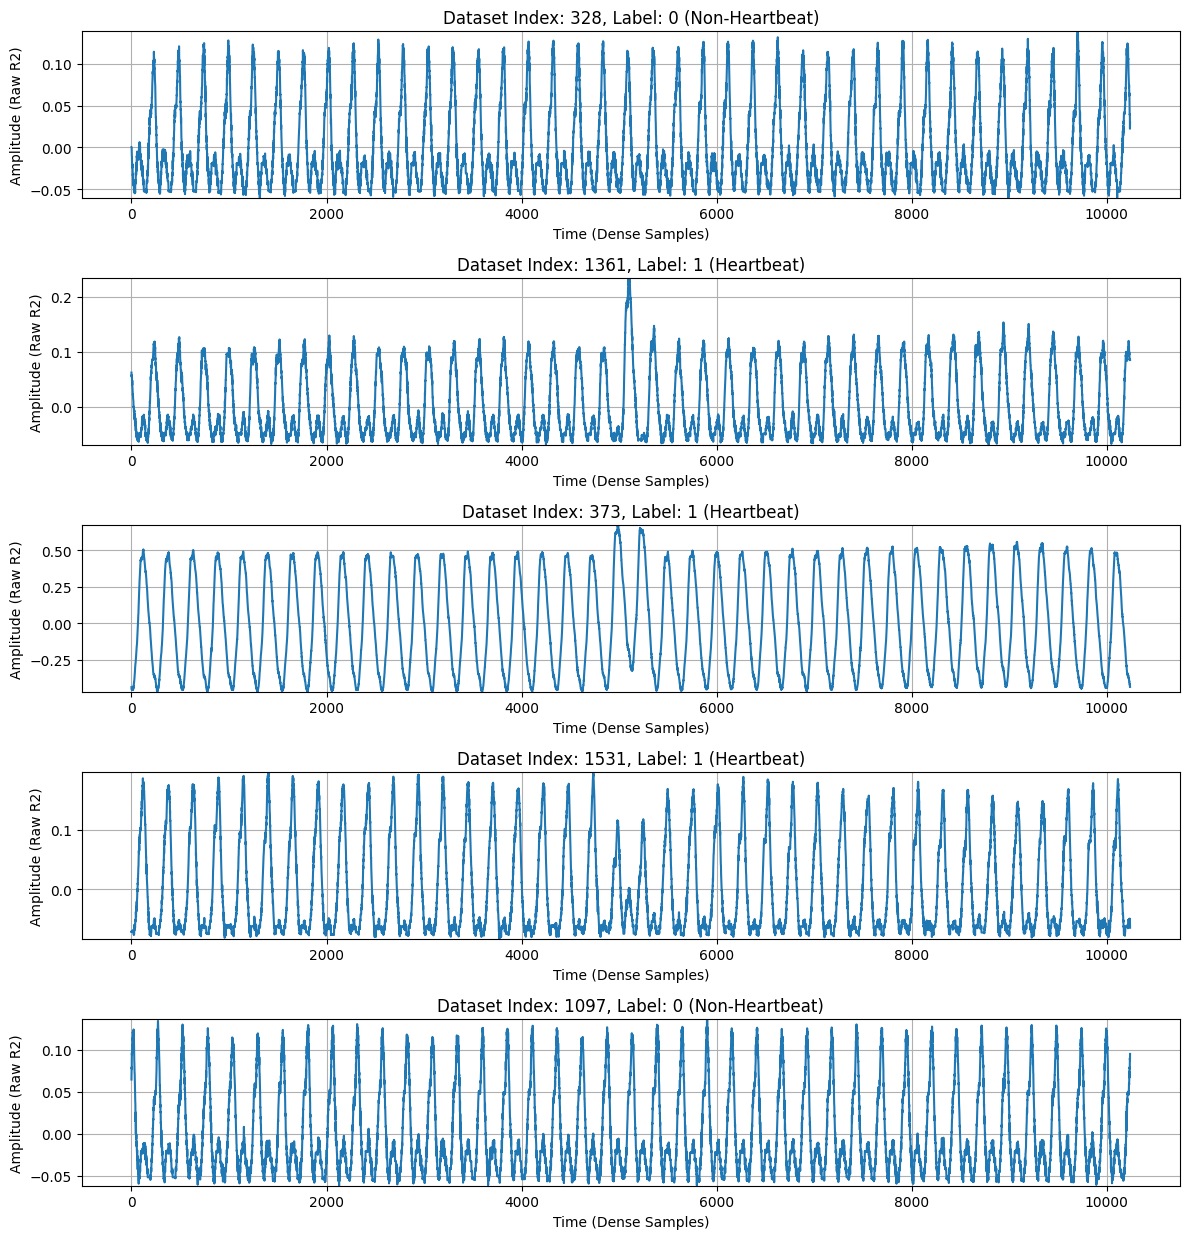

In [ ]:
# Plotting Function for Simulation Dataset Examples ---
def plot_simulation_examples(dataset, num_examples=5):
    """Plots random examples from the HeartbeatSimulationDataset."""
    if len(dataset) == 0:
        print("Dataset is empty, cannot plot examples.")
        return
    num_examples = min(num_examples, len(dataset)) # Don't try to plot more examples than exist
    indices = random.sample(range(len(dataset)), num_examples)

    print(f"\n--- Plotting {num_examples} Random Examples from Simulation Dataset ---")
    plt.figure(figsize=(12, 2.5 * num_examples)) # Adjusted figure size

    for i, idx in enumerate(indices):
        # Dataset returns the tuple (dense_raw_signal, label)
        dense_raw_signal, label = dataset[idx]
        # Convert tensor to numpy for plotting, ensure it's 1D
        signal_np = dense_raw_signal.squeeze().numpy()

        plt.subplot(num_examples, 1, i + 1)
        plt.plot(signal_np)
        class_name = "Heartbeat" if label.item() == 1 else "Non-Heartbeat"
        plt.title(f"Dataset Index: {idx}, Label: {label.item()} ({class_name})")

        # Auto-adjust y-limits based on data range
        ymin, ymax = signal_np.min(), signal_np.max()
        yrange = ymax - ymin
        print(yrange)
        plt.ylim([ymin , ymax ]) # Add small padding

        plt.xlabel("Time (Dense Samples)")
        plt.ylabel("Amplitude (Raw R2)")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot examples from the training split of the simulation dataset
plot_simulation_examples(train_dataset_sim, num_examples=5)

In [ ]:
import torch
import torch.nn.functional as F

def torch_downsample_to_length(signal_tensor, final_length, axis=-1):
    """
    Downsamples a tensor along a given axis to a specific final length using interpolation.
    Args:
        signal_tensor (torch.Tensor): Input tensor (e.g., B, T or B, C, T)
        final_length (int): Target length along the specified axis.
        axis (int): Axis along which to downsample.
    Returns:
        torch.Tensor: Downsampled tensor.
    """
    # Ensure axis is positive
    if axis < 0:
        axis = signal_tensor.ndim + axis

    original_shape = list(signal_tensor.shape)
    if original_shape[axis] == final_length:
        return signal_tensor # No downsampling needed

    # Need shape (B, C, T_orig) for interpolate
    needs_unsqueeze = False
    channel_axis = 1
    target_axis_temp = axis

    if signal_tensor.ndim == 2: # (B, T)
        signal_tensor = signal_tensor.unsqueeze(channel_axis) # -> (B, 1, T)
        needs_unsqueeze = True
        if target_axis_temp == 0: target_axis_temp = 0
        elif target_axis_temp == 1: target_axis_temp = 2

    # Interpolate expects the dimension being resized to be the last one
    current_dim_to_resize = target_axis_temp
    last_dim = signal_tensor.ndim - 1
    if current_dim_to_resize != last_dim:
        dims = list(range(signal_tensor.ndim))
        dims[current_dim_to_resize], dims[last_dim] = dims[last_dim], dims[current_dim_to_resize]
        signal_tensor = signal_tensor.permute(*dims)

    downsampled = F.interpolate(signal_tensor, size=final_length, mode='linear', align_corners=False)

    if current_dim_to_resize != last_dim:
        # Swap back the dimensions
        downsampled = downsampled.permute(*dims) # Apply the same permutation

    # Remove channel dimension if added
    if needs_unsqueeze:
        downsampled = downsampled.squeeze(channel_axis)

    return downsampled


def simulate_adc(signal_tensor, noise_std, final_length):
    """
    Simulates ADC by adding noise and then downsampling.
    Args:
        signal_tensor (torch.Tensor): Input signal (B, T_dense or B, 1, T_dense).
                                     Assumes time is the last dimension.
        noise_std (float): Standard deviation of Gaussian noise to add.
        final_length (int): The target length after downsampling (digitization).
    Returns:
        torch.Tensor: Digitized signal (B, final_length or B, 1, final_length).
    """

    noise = torch.randn_like(signal_tensor) * noise_std
    noisy_signal = signal_tensor + noise

    digitized_signal = torch_downsample_to_length(noisy_signal, final_length, axis=-1)

    return digitized_signal

In [ ]:
class LearnableAnalogFilter(nn.Module):
    """
    A single, learnable 1D convolutional layer acting as the simulated
    analog filter. Preserves the input sequence length.
    """
    def __init__(self, kernel_size, in_channels=1, out_channels=1):
        super().__init__()
        # Ensure kernel size is odd for symmetric 'same' padding
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for 'same' padding calculation.")

        self.kernel_size = kernel_size
        self.padding = (self.kernel_size - 1) // 2 # Calculate 'same' padding

        # Define the single convolutional layer
        self.conv_filter = nn.Conv1d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=self.kernel_size,
            stride=1,              # Stride=1 to preserve length
            padding=self.padding,  # Use calculated 'same' padding
            bias=False             # Typically no bias for simple filter kernels
        )
        print(f"Initialized LearnableAnalogFilter: kernel_size={self.kernel_size}, padding={self.padding}")

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor, shape (batch_size, in_channels, length)
        Returns:
            torch.Tensor: Output tensor, shape (batch_size, out_channels, length)
        """
        # Apply the learned filter
        filtered_x = self.conv_filter(x)
        return filtered_x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EndToEndModel(nn.Module):
    def __init__(self, filter_kernel_size, cnn_input_len, use_filter=True, num_classes=2):
        """
        End-to-end model with a trainable filter layer.

        Args:
            filter_kernel_size (int): Kernel size for the LearnableAnalogFilter.
            cnn_input_len (int): The final length expected by the CNN backend after ADC/pooling.
            num_classes (int): Number of output classes.
        """
        super().__init__()
        self.cnn_input_len = cnn_input_len
        self.use_filter = use_filter

        #  Instantiate the Learnable Filter (TRAINABLE)
        if self.use_filter:
          self.filter = LearnableAnalogFilter(kernel_size=filter_kernel_size)

        #  Differentiable Downsampler for TRAINING path
        self.train_downsampler = nn.AdaptiveAvgPool1d(self.cnn_input_len)

        #  Define the CNN backend (same as before)
        self.cnn_backend = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding='same'),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(32, 64, kernel_size=5, padding='same'),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),

            nn.Conv1d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        #  Calculate flattened feature dimension AFTER CNN backend
        with torch.no_grad():
            # Need to ensure dummy input matches expected input dim of cnn_backend
            dummy_input = torch.zeros(1, 1, self.cnn_input_len) # Input is (B, C=1, L=cnn_input_len)
            dummy_output = self.cnn_backend(dummy_input)
            self._feat_dim = dummy_output.shape[1] * dummy_output.shape[2] # C_out * L_out

        # Define the MLP classifier
        self.mlp = nn.Sequential(
            nn.Linear(self._feat_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3), # Keep dropout for regularization
            nn.Linear(256, num_classes)
        )

    def forward(self, input_signal, power_scale_factor, noise_std_sim=None, simulate_adc_func=None):
        """
        Forward pass with conditional logic for training vs evaluation.

        Args:
            input_signal (torch.Tensor): Batch of input signals (B, T_input_len).
                                         (e.g., pre-downsampled, scaled raw data).
            power_scale_factor (float): Factor to scale the input signal amplitude.
            noise_std_sim (float, optional): Scaled noise std dev for ADC sim.
                                             Required if model is in eval mode. Defaults to None.
            simulate_adc_func (callable, optional): Function for noise+downsampling.
                                                     Required if model is in eval mode. Defaults to None.

        Returns:
            torch.Tensor: Logits for classification (B, num_classes).
        """

        x = input_signal.to(next(self.parameters()).device) * power_scale_factor


        if x.ndim == 2: x = x.unsqueeze(1) # Shape: (B, 1, T_input_len)

        if self.use_filter:
          x = self.filter(x) # Output shape: (B, 1, T_input_len)


        if self.training:
            #  Use differentiable downsampling (NO noise/ADC)
            if noise_std is not None and noise_std > 0:
                x = x + torch.randn_like(x) * noise_std
            x_for_cnn = self.train_downsampler(x) # Shape: (B, 1, cnn_input_len)

        else:
            #  Use simulate_adc function
            if noise_std_sim is None or simulate_adc_func is None:
                raise ValueError("In eval mode, 'noise_std_sim' and 'simulate_adc_func' must be provided.")


            x_digitized = simulate_adc_func(x, noise_std_sim, self.cnn_input_len)

            # Ensure output of simulate_adc has channel dim for CNN
            if x_digitized.ndim == 2:
                x_for_cnn = x_digitized.unsqueeze(1) # Shape: (B, 1, cnn_input_len)
            else:
                x_for_cnn = x_digitized # Assume already (B, 1, cnn_input_len)

        #  Pass through CNN backend & MLP (Common to both paths)
        features = self.cnn_backend(x_for_cnn)
        features = features.view(features.size(0), -1) # Flatten
        logits = self.mlp(features)

        return logits

In [ ]:
import torch.optim as optim
from tqdm.auto import tqdm # Optional: For progress bars
import matplotlib.pyplot as plt
import time # To time training runs
from torch.optim.lr_scheduler import ReduceLROnPlateau

#  Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#  Simulation Parameters
sigma_focus        = [0.012, 0.017, 0.025, 0.035]          # four key noise levels
add_power_levels   = [-4, -8, -11, -14, -20]               # five new powers


print("new powers :", power_levels_db)
print("new sigmas :", noise_std_sim)

# for quick lookup
force_set = set(force_rerun_pairs)

filter_kernel_s = 1001

# Calculate Nyquist samples and CNN input length
fs_orig = 59750.0 # computed alue

input_tensor_length = 10240
T_seg = input_tensor_length / (fs_orig / downsample_factor)
f_Nyquist = 500.0 # Your chosen Nyquist rate in Hz
N_nyquist_samples = int(round(T_seg * f_Nyquist))
print(f"Input Tensor Length (post pre-downsample): {input_tensor_length}")
print(f"Segment Duration (T_seg): {T_seg:.4f} s")
print(f"Nyquist Rate: {f_Nyquist} Hz")
print(f"Calculated N_nyquist_samples (k=1 length): {N_nyquist_samples}")

cnn_input_len = N_nyquist_samples # CNN backend expects this length after ADC/pooling

num_epochs_sim = 15      # Epochs for training per setting
learning_rate_sim = 1e-4 # Learning rate for the whole end-to-end model

#  Store results
results = {}

#  Loss Function
criterion_cls = nn.CrossEntropyLoss()

#  Evaluation Function (Needs simulate_adc passed)
def evaluate_e2e(model, loader, device, power_scale_factor, noise_std_sim, adc_func):
    """Evaluates the EndToEndModel."""
    model.eval() # Set model to evaluation mode
    total, correct, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for input_batch, labels_batch in loader: # Use appropriate variable names
            input_batch = input_batch.to(device)
            labels_batch = labels_batch.long().to(device)

            logits = model(input_batch, power_scale_factor, noise_std_sim, adc_func)
            loss = criterion_cls(logits, labels_batch)

            running_loss += loss.item() * input_batch.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels_batch).sum().item()
            total += input_batch.size(0)

    avg_loss = running_loss / total if total > 0 else 0
    accuracy = correct / total if total > 0 else 0
    return avg_loss, accuracy

Using device: cpu
new powers : [-24, -20, -14, -12, -11, -8, -4]
new sigmas : [0.012, 0.017, 0.025, 0.035]
Using upscale_factor=1e+09 for noise scaling (even if noise=0 now).
Input Tensor Length (post pre-downsample): 10240
Segment Duration (T_seg): 0.6855 s
Nyquist Rate: 500.0 Hz
Calculated N_nyquist_samples (k=1 length): 343


In [ ]:
start_time_total = time.time()

for power_db in power_levels_db:
    power_scale_factor = 10**(power_db / 20.0)
    results[power_db] = {}
    print(f"\n===== Processing Power Level: {power_db} dB =====")

    for noise_std in noise_std_sim:
        already_done = (power_db in all_results and noise_std in all_results[power_db])
        must_rerun   = (power_db, noise_std) in force_set
        if already_done and not must_rerun:
            continue

        results[power_db][noise_std] = {}
        print(f"\n--- Running Simulation: Power {power_db} dB, Noise Std {noise_std:.2e} ---")

        # --- Run for both Filtered and Conventional Paths ---
        for use_filter_flag in [True, False]:
            run_name = f"E2E Filtered" if use_filter_flag else "E2E Conventional"
            print(f"--- Starting: {run_name} Path ---")
            start_time_run = time.time()

            # Instantiate the EndToEndModel for this run
            model = EndToEndModel(
                filter_kernel_size=filter_kernel_s,
                cnn_input_len=cnn_input_len,
                use_filter=use_filter_flag, # Control if filter layer is created/used
                num_classes=2
            ).to(device)

            # Optimizer targets ALL trainable parameters
            optimizer = optim.Adam(model.parameters(), lr=learning_rate_sim)
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

            best_val_acc = 0.0

            # --- Training Loop ---
            for epoch in range(num_epochs_sim):
                model.train() # Set model to TRAINING mode
                running_loss, correct, total = 0.0, 0, 0
                # Ensure train_loader_e2e is defined and yields (input, label)
                pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs_sim} [{run_name} T]", leave=False)

                for input_batch, labels_batch in pbar:
                    input_batch = input_batch.to(device)
                    labels_batch = labels_batch.to(device)

                    optimizer.zero_grad()
                    logits = model(input_batch, power_scale_factor)
                    loss = criterion_cls(logits, labels_batch)

                    if torch.isnan(loss) or torch.isinf(loss):
                        print(f"Warning: Invalid loss encountered ({loss.item()}). Skipping batch.")
                        continue

                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * input_batch.size(0)
                    preds = logits.argmax(dim=1)
                    correct += (preds == labels_batch).sum().item()
                    total += input_batch.size(0)
                    if total > 0: pbar.set_postfix({'loss': running_loss/total, 'acc': correct/total})
                    else: pbar.set_postfix({'loss': 0, 'acc': 0})

                train_loss = running_loss / total if total > 0 else 0
                train_acc = correct / total if total > 0 else 0

                # --- Validation Step ---
                # Pass noise_std_sim and the simulate_adc function reference
                val_loss, val_acc = evaluate_e2e(model, val_loader, device,
                                                 power_scale_factor, noise_std, simulate_adc)

                print(f"Epoch [{epoch+1}/{num_epochs_sim}] {run_name} | "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

                scheduler.step(val_loss)

                if val_acc > best_val_acc: best_val_acc = val_acc
                # (Optional saving logic for best epoch model)

            results[power_db][noise_std][run_name] = best_val_acc
            run_duration = time.time() - start_time_run
            print(f"--- Finished {run_name}: Best Val Acc = {best_val_acc:.4f} (Duration: {run_duration:.2f}s) ---")

# --- (End loops and results analysis) ---
end_time_total = time.time()
total_duration = end_time_total - start_time_total
print(f"\n===== Simulation Run Complete =====")
print(f"Total Duration: {total_duration:.2f} seconds")
print("\n--- Simulation Results Summary ---")
print(results)


===== Processing Power Level: -24 dB =====

--- Running Simulation: Power -24 dB, Noise Std 1.20e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7141, Train Acc: 0.5200 | Val Loss: 0.7585, Val Acc: 0.4800


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.6065, Train Acc: 0.6556 | Val Loss: 2.2119, Val Acc: 0.5425


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.2823, Train Acc: 0.8931 | Val Loss: 1.5110, Val Acc: 0.6350


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1574, Train Acc: 0.9494 | Val Loss: 1.0655, Val Acc: 0.7200


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.1281, Train Acc: 0.9619 | Val Loss: 1.0299, Val Acc: 0.7325


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.1086, Train Acc: 0.9712 | Val Loss: 1.0395, Val Acc: 0.7550


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0963, Train Acc: 0.9750 | Val Loss: 1.1117, Val Acc: 0.7450


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0942, Train Acc: 0.9731 | Val Loss: 1.0893, Val Acc: 0.7425


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0932, Train Acc: 0.9738 | Val Loss: 1.0198, Val Acc: 0.7350


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0876, Train Acc: 0.9738 | Val Loss: 1.0349, Val Acc: 0.7450


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0984, Train Acc: 0.9712 | Val Loss: 1.1899, Val Acc: 0.7350


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0989, Train Acc: 0.9725 | Val Loss: 0.9931, Val Acc: 0.7625


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0967, Train Acc: 0.9712 | Val Loss: 0.9582, Val Acc: 0.7525


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0857, Train Acc: 0.9738 | Val Loss: 0.9918, Val Acc: 0.7550


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0903, Train Acc: 0.9725 | Val Loss: 1.0446, Val Acc: 0.7500
--- Finished E2E Filtered: Best Val Acc = 0.7625 (Duration: 859.26s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7268, Train Acc: 0.5188 | Val Loss: 0.6902, Val Acc: 0.5150


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6770, Train Acc: 0.5850 | Val Loss: 0.7854, Val Acc: 0.4775


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.6524, Train Acc: 0.6056 | Val Loss: 0.7788, Val Acc: 0.5150


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.5637, Train Acc: 0.7206 | Val Loss: 1.2310, Val Acc: 0.4900


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.5005, Train Acc: 0.7462 | Val Loss: 1.4575, Val Acc: 0.5025


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.4653, Train Acc: 0.7794 | Val Loss: 1.3564, Val Acc: 0.4900


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.4582, Train Acc: 0.7906 | Val Loss: 1.3782, Val Acc: 0.4725


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.4521, Train Acc: 0.7944 | Val Loss: 1.2574, Val Acc: 0.5050


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.4445, Train Acc: 0.7950 | Val Loss: 1.5144, Val Acc: 0.4900


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.4316, Train Acc: 0.8087 | Val Loss: 1.3311, Val Acc: 0.5025


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.4233, Train Acc: 0.8125 | Val Loss: 1.2740, Val Acc: 0.4975


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.4365, Train Acc: 0.7844 | Val Loss: 1.3347, Val Acc: 0.4950


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.4405, Train Acc: 0.7969 | Val Loss: 1.4011, Val Acc: 0.5050


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.4348, Train Acc: 0.7950 | Val Loss: 1.2759, Val Acc: 0.5375


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.4300, Train Acc: 0.7919 | Val Loss: 1.3160, Val Acc: 0.5100
--- Finished E2E Conventional: Best Val Acc = 0.5375 (Duration: 94.19s) ---

--- Running Simulation: Power -24 dB, Noise Std 1.70e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7081, Train Acc: 0.5138 | Val Loss: 0.7461, Val Acc: 0.5025


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.6242, Train Acc: 0.6481 | Val Loss: 1.1549, Val Acc: 0.5100


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.3115, Train Acc: 0.8850 | Val Loss: 3.2821, Val Acc: 0.5100


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1702, Train Acc: 0.9463 | Val Loss: 1.4409, Val Acc: 0.6300


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.1344, Train Acc: 0.9581 | Val Loss: 1.6174, Val Acc: 0.6100


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.1188, Train Acc: 0.9637 | Val Loss: 1.5644, Val Acc: 0.6300


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.1172, Train Acc: 0.9656 | Val Loss: 1.5221, Val Acc: 0.6275


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.1111, Train Acc: 0.9650 | Val Loss: 1.6550, Val Acc: 0.6200


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.1163, Train Acc: 0.9644 | Val Loss: 1.4896, Val Acc: 0.6275


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.1157, Train Acc: 0.9663 | Val Loss: 1.2683, Val Acc: 0.6550


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.1156, Train Acc: 0.9619 | Val Loss: 1.5761, Val Acc: 0.6525


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0993, Train Acc: 0.9725 | Val Loss: 1.7276, Val Acc: 0.6350


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.1145, Train Acc: 0.9625 | Val Loss: 1.3016, Val Acc: 0.6500


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0994, Train Acc: 0.9731 | Val Loss: 1.3898, Val Acc: 0.6250


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.1067, Train Acc: 0.9675 | Val Loss: 1.3684, Val Acc: 0.6750
--- Finished E2E Filtered: Best Val Acc = 0.6750 (Duration: 849.70s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7164, Train Acc: 0.5319 | Val Loss: 0.8228, Val Acc: 0.4675


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6924, Train Acc: 0.5619 | Val Loss: 0.8372, Val Acc: 0.4625


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.6503, Train Acc: 0.6088 | Val Loss: 1.2076, Val Acc: 0.4750


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.6103, Train Acc: 0.6744 | Val Loss: 1.2513, Val Acc: 0.4975


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.5771, Train Acc: 0.6906 | Val Loss: 2.0674, Val Acc: 0.4650


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.5326, Train Acc: 0.7262 | Val Loss: 1.2242, Val Acc: 0.5150


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.5349, Train Acc: 0.7225 | Val Loss: 1.4054, Val Acc: 0.4950


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.5293, Train Acc: 0.7319 | Val Loss: 1.1925, Val Acc: 0.5175


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.5360, Train Acc: 0.7225 | Val Loss: 1.4752, Val Acc: 0.4675


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.5158, Train Acc: 0.7381 | Val Loss: 1.3654, Val Acc: 0.5050


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.5405, Train Acc: 0.7269 | Val Loss: 1.3549, Val Acc: 0.5025


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.5165, Train Acc: 0.7412 | Val Loss: 1.3582, Val Acc: 0.5125


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.5188, Train Acc: 0.7375 | Val Loss: 1.3833, Val Acc: 0.4975


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.5257, Train Acc: 0.7312 | Val Loss: 1.3223, Val Acc: 0.5150


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.5288, Train Acc: 0.7344 | Val Loss: 1.2987, Val Acc: 0.5300
--- Finished E2E Conventional: Best Val Acc = 0.5300 (Duration: 95.40s) ---

--- Running Simulation: Power -24 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7255, Train Acc: 0.4950 | Val Loss: 0.7231, Val Acc: 0.4675


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.7017, Train Acc: 0.5119 | Val Loss: 1.0596, Val Acc: 0.4700


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.6873, Train Acc: 0.5437 | Val Loss: 0.6993, Val Acc: 0.5425


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.6718, Train Acc: 0.5719 | Val Loss: 0.7492, Val Acc: 0.5375


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.5972, Train Acc: 0.6850 | Val Loss: 0.9593, Val Acc: 0.5550


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.4731, Train Acc: 0.7775 | Val Loss: 0.9315, Val Acc: 0.5650


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.3128, Train Acc: 0.8719 | Val Loss: 1.1404, Val Acc: 0.5550


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.2651, Train Acc: 0.8988 | Val Loss: 0.8274, Val Acc: 0.6325


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.2594, Train Acc: 0.9038 | Val Loss: 0.9253, Val Acc: 0.6125


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.2387, Train Acc: 0.9131 | Val Loss: 0.9963, Val Acc: 0.6200


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.2295, Train Acc: 0.9163 | Val Loss: 1.0775, Val Acc: 0.5825


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.2270, Train Acc: 0.9237 | Val Loss: 1.0407, Val Acc: 0.6100


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.2279, Train Acc: 0.9144 | Val Loss: 1.0190, Val Acc: 0.6100


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.2185, Train Acc: 0.9263 | Val Loss: 1.1191, Val Acc: 0.5900


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.2058, Train Acc: 0.9300 | Val Loss: 0.7974, Val Acc: 0.6500
--- Finished E2E Filtered: Best Val Acc = 0.6500 (Duration: 850.76s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7328, Train Acc: 0.5056 | Val Loss: 0.7087, Val Acc: 0.5025


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.7160, Train Acc: 0.5088 | Val Loss: 0.8015, Val Acc: 0.5325


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.6912, Train Acc: 0.5156 | Val Loss: 0.7539, Val Acc: 0.4825


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.6844, Train Acc: 0.5381 | Val Loss: 0.7810, Val Acc: 0.4750


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.6724, Train Acc: 0.5875 | Val Loss: 0.8291, Val Acc: 0.5525


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.6655, Train Acc: 0.5975 | Val Loss: 0.7698, Val Acc: 0.5150


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.6596, Train Acc: 0.6056 | Val Loss: 0.7644, Val Acc: 0.5250


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.6592, Train Acc: 0.6000 | Val Loss: 0.7432, Val Acc: 0.5500


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.6563, Train Acc: 0.6106 | Val Loss: 0.7900, Val Acc: 0.5175


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.6522, Train Acc: 0.6125 | Val Loss: 0.8190, Val Acc: 0.4875


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.6556, Train Acc: 0.5969 | Val Loss: 0.7950, Val Acc: 0.4900


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.6535, Train Acc: 0.6012 | Val Loss: 0.7767, Val Acc: 0.5300


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.6558, Train Acc: 0.6138 | Val Loss: 0.7609, Val Acc: 0.5300


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.6524, Train Acc: 0.6119 | Val Loss: 0.8225, Val Acc: 0.4600


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.6519, Train Acc: 0.6156 | Val Loss: 0.8015, Val Acc: 0.5150
--- Finished E2E Conventional: Best Val Acc = 0.5525 (Duration: 97.67s) ---

--- Running Simulation: Power -24 dB, Noise Std 3.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7150, Train Acc: 0.5100 | Val Loss: 0.9608, Val Acc: 0.4700


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.6998, Train Acc: 0.5044 | Val Loss: 1.2010, Val Acc: 0.4700


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.6957, Train Acc: 0.5006 | Val Loss: 0.9053, Val Acc: 0.4700


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.6945, Train Acc: 0.5081 | Val Loss: 0.7143, Val Acc: 0.5125


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.6767, Train Acc: 0.5500 | Val Loss: 1.5892, Val Acc: 0.4700


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.5873, Train Acc: 0.6794 | Val Loss: 1.7870, Val Acc: 0.4775


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.3252, Train Acc: 0.8750 | Val Loss: 1.7829, Val Acc: 0.5750


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.2369, Train Acc: 0.9087 | Val Loss: 1.6735, Val Acc: 0.5725


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.2074, Train Acc: 0.9325 | Val Loss: 1.9942, Val Acc: 0.5275


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.2035, Train Acc: 0.9294 | Val Loss: 2.1431, Val Acc: 0.5575


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.1926, Train Acc: 0.9350 | Val Loss: 2.0485, Val Acc: 0.5450


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.1936, Train Acc: 0.9275 | Val Loss: 2.0547, Val Acc: 0.5775


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.1894, Train Acc: 0.9319 | Val Loss: 2.3771, Val Acc: 0.5225


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.1831, Train Acc: 0.9387 | Val Loss: 2.0428, Val Acc: 0.5875


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.1884, Train Acc: 0.9387 | Val Loss: 2.2492, Val Acc: 0.5650
--- Finished E2E Filtered: Best Val Acc = 0.5875 (Duration: 847.54s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7247, Train Acc: 0.5012 | Val Loss: 0.7108, Val Acc: 0.5175


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.7014, Train Acc: 0.5056 | Val Loss: 0.7368, Val Acc: 0.4700


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.6944, Train Acc: 0.5363 | Val Loss: 0.7526, Val Acc: 0.4700


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.6896, Train Acc: 0.5256 | Val Loss: 0.7586, Val Acc: 0.5175


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.6798, Train Acc: 0.5525 | Val Loss: 0.9355, Val Acc: 0.5400


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.6799, Train Acc: 0.5487 | Val Loss: 0.8111, Val Acc: 0.4875


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.6784, Train Acc: 0.5487 | Val Loss: 0.8308, Val Acc: 0.5050


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.6741, Train Acc: 0.5550 | Val Loss: 0.8661, Val Acc: 0.5250


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.6775, Train Acc: 0.5537 | Val Loss: 0.8291, Val Acc: 0.4825


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.6782, Train Acc: 0.5369 | Val Loss: 0.8539, Val Acc: 0.5250


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.6714, Train Acc: 0.5756 | Val Loss: 0.8295, Val Acc: 0.4975


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.6700, Train Acc: 0.5819 | Val Loss: 0.8660, Val Acc: 0.5075


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.6727, Train Acc: 0.5550 | Val Loss: 0.8051, Val Acc: 0.5175


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.6722, Train Acc: 0.5756 | Val Loss: 0.8495, Val Acc: 0.4775


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.6671, Train Acc: 0.5881 | Val Loss: 0.8488, Val Acc: 0.5050
--- Finished E2E Conventional: Best Val Acc = 0.5400 (Duration: 95.37s) ---

===== Processing Power Level: -20 dB =====

--- Running Simulation: Power -20 dB, Noise Std 1.20e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.6983, Train Acc: 0.5587 | Val Loss: 0.6978, Val Acc: 0.5525


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.3679, Train Acc: 0.8506 | Val Loss: 2.5491, Val Acc: 0.4900


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1545, Train Acc: 0.9537 | Val Loss: 0.7957, Val Acc: 0.7125


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1004, Train Acc: 0.9756 | Val Loss: 0.9218, Val Acc: 0.7200


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0883, Train Acc: 0.9700 | Val Loss: 0.6449, Val Acc: 0.7800


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0690, Train Acc: 0.9775 | Val Loss: 0.6196, Val Acc: 0.7825


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0563, Train Acc: 0.9800 | Val Loss: 0.7139, Val Acc: 0.8050


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0400, Train Acc: 0.9869 | Val Loss: 0.7278, Val Acc: 0.7900


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0377, Train Acc: 0.9869 | Val Loss: 0.8477, Val Acc: 0.7825


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0357, Train Acc: 0.9850 | Val Loss: 0.6350, Val Acc: 0.8650


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0260, Train Acc: 0.9912 | Val Loss: 0.5409, Val Acc: 0.8575


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0248, Train Acc: 0.9931 | Val Loss: 0.4601, Val Acc: 0.8950


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0237, Train Acc: 0.9925 | Val Loss: 0.5128, Val Acc: 0.8700


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0308, Train Acc: 0.9906 | Val Loss: 0.5139, Val Acc: 0.8825


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0334, Train Acc: 0.9881 | Val Loss: 0.4635, Val Acc: 0.8775
--- Finished E2E Filtered: Best Val Acc = 0.8950 (Duration: 847.22s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7126, Train Acc: 0.5369 | Val Loss: 0.6840, Val Acc: 0.5675


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6036, Train Acc: 0.6512 | Val Loss: 0.9279, Val Acc: 0.4800


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.4153, Train Acc: 0.8281 | Val Loss: 1.2956, Val Acc: 0.5300


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.3124, Train Acc: 0.8681 | Val Loss: 2.0325, Val Acc: 0.5250


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.2588, Train Acc: 0.8938 | Val Loss: 2.6422, Val Acc: 0.5200


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.2257, Train Acc: 0.9144 | Val Loss: 2.1712, Val Acc: 0.5075


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.2147, Train Acc: 0.9125 | Val Loss: 2.5219, Val Acc: 0.5150


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.2143, Train Acc: 0.9175 | Val Loss: 2.5280, Val Acc: 0.4975


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.2105, Train Acc: 0.9213 | Val Loss: 2.4506, Val Acc: 0.5375


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.2180, Train Acc: 0.9150 | Val Loss: 2.0464, Val Acc: 0.5525


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.2165, Train Acc: 0.9137 | Val Loss: 2.3095, Val Acc: 0.5425


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.2049, Train Acc: 0.9219 | Val Loss: 2.3393, Val Acc: 0.5100


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.2131, Train Acc: 0.9137 | Val Loss: 2.4409, Val Acc: 0.5300


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.2055, Train Acc: 0.9219 | Val Loss: 2.5224, Val Acc: 0.5450


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.2070, Train Acc: 0.9200 | Val Loss: 2.1625, Val Acc: 0.5275
--- Finished E2E Conventional: Best Val Acc = 0.5675 (Duration: 96.17s) ---

--- Running Simulation: Power -20 dB, Noise Std 1.70e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7307, Train Acc: 0.5169 | Val Loss: 1.0992, Val Acc: 0.4700


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.6288, Train Acc: 0.6431 | Val Loss: 1.9053, Val Acc: 0.4700


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.2694, Train Acc: 0.9062 | Val Loss: 2.2256, Val Acc: 0.5125


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1819, Train Acc: 0.9394 | Val Loss: 0.8923, Val Acc: 0.6600


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.1332, Train Acc: 0.9500 | Val Loss: 1.2737, Val Acc: 0.6350


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.1215, Train Acc: 0.9625 | Val Loss: 0.7994, Val Acc: 0.7325


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.1174, Train Acc: 0.9644 | Val Loss: 0.7676, Val Acc: 0.7875


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.1059, Train Acc: 0.9663 | Val Loss: 0.7155, Val Acc: 0.7750


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0894, Train Acc: 0.9744 | Val Loss: 0.7612, Val Acc: 0.7825


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0702, Train Acc: 0.9775 | Val Loss: 0.7386, Val Acc: 0.7725


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0807, Train Acc: 0.9712 | Val Loss: 0.5544, Val Acc: 0.8550


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0664, Train Acc: 0.9800 | Val Loss: 0.8071, Val Acc: 0.7825


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0474, Train Acc: 0.9856 | Val Loss: 0.7130, Val Acc: 0.8175


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0488, Train Acc: 0.9856 | Val Loss: 0.9423, Val Acc: 0.7800


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0442, Train Acc: 0.9844 | Val Loss: 0.6969, Val Acc: 0.8050
--- Finished E2E Filtered: Best Val Acc = 0.8550 (Duration: 836.84s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7303, Train Acc: 0.5262 | Val Loss: 0.7573, Val Acc: 0.4725


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6397, Train Acc: 0.6362 | Val Loss: 0.7283, Val Acc: 0.5275


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.5808, Train Acc: 0.6969 | Val Loss: 0.9172, Val Acc: 0.5125


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.4759, Train Acc: 0.7731 | Val Loss: 1.5270, Val Acc: 0.4975


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.4203, Train Acc: 0.8100 | Val Loss: 2.2941, Val Acc: 0.4825


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.3677, Train Acc: 0.8369 | Val Loss: 2.7728, Val Acc: 0.4875


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.3346, Train Acc: 0.8575 | Val Loss: 2.4330, Val Acc: 0.5300


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.3443, Train Acc: 0.8488 | Val Loss: 2.5440, Val Acc: 0.4950


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.3400, Train Acc: 0.8519 | Val Loss: 2.7020, Val Acc: 0.4925


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.3112, Train Acc: 0.8644 | Val Loss: 3.0058, Val Acc: 0.4750


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.3151, Train Acc: 0.8656 | Val Loss: 2.7811, Val Acc: 0.4975


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.3270, Train Acc: 0.8594 | Val Loss: 2.9825, Val Acc: 0.4925


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.3292, Train Acc: 0.8500 | Val Loss: 2.6057, Val Acc: 0.4925


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.3291, Train Acc: 0.8625 | Val Loss: 2.8545, Val Acc: 0.4850


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.3330, Train Acc: 0.8512 | Val Loss: 2.5867, Val Acc: 0.5050
--- Finished E2E Conventional: Best Val Acc = 0.5300 (Duration: 96.12s) ---

--- Running Simulation: Power -20 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7151, Train Acc: 0.5312 | Val Loss: 0.9627, Val Acc: 0.4625


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.5701, Train Acc: 0.6956 | Val Loss: 3.7220, Val Acc: 0.4700


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.2596, Train Acc: 0.9113 | Val Loss: 1.8607, Val Acc: 0.5550


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1867, Train Acc: 0.9394 | Val Loss: 1.9165, Val Acc: 0.5375


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.1498, Train Acc: 0.9494 | Val Loss: 1.4539, Val Acc: 0.6375


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.1359, Train Acc: 0.9537 | Val Loss: 1.2122, Val Acc: 0.6800


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.1303, Train Acc: 0.9587 | Val Loss: 1.1928, Val Acc: 0.6925


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.1387, Train Acc: 0.9550 | Val Loss: 0.9468, Val Acc: 0.7250


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.1273, Train Acc: 0.9613 | Val Loss: 1.1811, Val Acc: 0.6650


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.1219, Train Acc: 0.9613 | Val Loss: 0.9133, Val Acc: 0.7400


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.1228, Train Acc: 0.9556 | Val Loss: 1.0472, Val Acc: 0.7075


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.1193, Train Acc: 0.9594 | Val Loss: 1.1977, Val Acc: 0.6800


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.1248, Train Acc: 0.9600 | Val Loss: 1.2523, Val Acc: 0.6775


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.1176, Train Acc: 0.9619 | Val Loss: 1.0613, Val Acc: 0.6850


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.1281, Train Acc: 0.9600 | Val Loss: 1.1488, Val Acc: 0.6950
--- Finished E2E Filtered: Best Val Acc = 0.7400 (Duration: 854.40s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7166, Train Acc: 0.5288 | Val Loss: 0.7881, Val Acc: 0.4650


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6943, Train Acc: 0.5437 | Val Loss: 1.0027, Val Acc: 0.4700


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.6725, Train Acc: 0.5694 | Val Loss: 0.7138, Val Acc: 0.5150


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.6480, Train Acc: 0.6119 | Val Loss: 0.7730, Val Acc: 0.5225


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.6028, Train Acc: 0.6731 | Val Loss: 1.1691, Val Acc: 0.4875


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.5582, Train Acc: 0.7031 | Val Loss: 0.9087, Val Acc: 0.5325


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.5306, Train Acc: 0.7269 | Val Loss: 1.0528, Val Acc: 0.5450


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.4930, Train Acc: 0.7588 | Val Loss: 1.0930, Val Acc: 0.5075


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.5016, Train Acc: 0.7562 | Val Loss: 1.2143, Val Acc: 0.5100


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.4862, Train Acc: 0.7638 | Val Loss: 1.2782, Val Acc: 0.5250


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.4960, Train Acc: 0.7638 | Val Loss: 1.3727, Val Acc: 0.5400


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.4891, Train Acc: 0.7675 | Val Loss: 1.4444, Val Acc: 0.5275


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.4883, Train Acc: 0.7519 | Val Loss: 1.3329, Val Acc: 0.5000


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.4757, Train Acc: 0.7712 | Val Loss: 1.4227, Val Acc: 0.5300


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.4950, Train Acc: 0.7488 | Val Loss: 1.4314, Val Acc: 0.5125
--- Finished E2E Conventional: Best Val Acc = 0.5450 (Duration: 97.54s) ---

--- Running Simulation: Power -20 dB, Noise Std 3.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7111, Train Acc: 0.5144 | Val Loss: 1.4612, Val Acc: 0.4700


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.7141, Train Acc: 0.4913 | Val Loss: 0.7993, Val Acc: 0.4900


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.6938, Train Acc: 0.5212 | Val Loss: 0.7676, Val Acc: 0.5250


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.6843, Train Acc: 0.5537 | Val Loss: 1.1013, Val Acc: 0.4675


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.5124, Train Acc: 0.7531 | Val Loss: 2.7034, Val Acc: 0.4700


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.2475, Train Acc: 0.9131 | Val Loss: 1.2330, Val Acc: 0.6525


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.1902, Train Acc: 0.9381 | Val Loss: 1.0967, Val Acc: 0.6575


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.1510, Train Acc: 0.9500 | Val Loss: 0.9988, Val Acc: 0.6825


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.1580, Train Acc: 0.9506 | Val Loss: 1.3595, Val Acc: 0.6200


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.1443, Train Acc: 0.9487 | Val Loss: 1.2951, Val Acc: 0.6175


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.1454, Train Acc: 0.9481 | Val Loss: 1.2282, Val Acc: 0.6650


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.1464, Train Acc: 0.9531 | Val Loss: 1.3431, Val Acc: 0.6300


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.1402, Train Acc: 0.9556 | Val Loss: 1.3159, Val Acc: 0.6475


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.1402, Train Acc: 0.9550 | Val Loss: 1.1427, Val Acc: 0.6600


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.1351, Train Acc: 0.9550 | Val Loss: 1.4440, Val Acc: 0.6525
--- Finished E2E Filtered: Best Val Acc = 0.6825 (Duration: 838.86s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7375, Train Acc: 0.4950 | Val Loss: 0.7089, Val Acc: 0.5000


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6918, Train Acc: 0.5337 | Val Loss: 0.7239, Val Acc: 0.5125


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.6779, Train Acc: 0.5700 | Val Loss: 0.8006, Val Acc: 0.4750


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.6602, Train Acc: 0.6000 | Val Loss: 0.7772, Val Acc: 0.5350


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.6455, Train Acc: 0.6144 | Val Loss: 0.9748, Val Acc: 0.5025


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.6342, Train Acc: 0.6344 | Val Loss: 0.9897, Val Acc: 0.5025


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.6206, Train Acc: 0.6494 | Val Loss: 0.8895, Val Acc: 0.5150


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.6240, Train Acc: 0.6450 | Val Loss: 0.9491, Val Acc: 0.5100


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.6137, Train Acc: 0.6625 | Val Loss: 1.0270, Val Acc: 0.4850


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.6155, Train Acc: 0.6606 | Val Loss: 1.0475, Val Acc: 0.5000


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.6150, Train Acc: 0.6600 | Val Loss: 0.9832, Val Acc: 0.5100


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.6101, Train Acc: 0.6663 | Val Loss: 0.9842, Val Acc: 0.5350


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.6132, Train Acc: 0.6625 | Val Loss: 0.9818, Val Acc: 0.4925


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.6114, Train Acc: 0.6625 | Val Loss: 0.9743, Val Acc: 0.5100


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.6037, Train Acc: 0.6719 | Val Loss: 1.0451, Val Acc: 0.4850
--- Finished E2E Conventional: Best Val Acc = 0.5350 (Duration: 99.87s) ---

===== Processing Power Level: -14 dB =====

--- Running Simulation: Power -14 dB, Noise Std 1.20e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5074, Train Acc: 0.7331 | Val Loss: 0.6231, Val Acc: 0.6950


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1487, Train Acc: 0.9581 | Val Loss: 1.7466, Val Acc: 0.6925


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1015, Train Acc: 0.9738 | Val Loss: 0.5007, Val Acc: 0.8200


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0833, Train Acc: 0.9744 | Val Loss: 0.5377, Val Acc: 0.8475


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0619, Train Acc: 0.9825 | Val Loss: 0.5020, Val Acc: 0.8350


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0632, Train Acc: 0.9819 | Val Loss: 0.5027, Val Acc: 0.8325


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0489, Train Acc: 0.9850 | Val Loss: 0.5107, Val Acc: 0.8225


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0382, Train Acc: 0.9888 | Val Loss: 0.5449, Val Acc: 0.8475


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0413, Train Acc: 0.9856 | Val Loss: 0.3983, Val Acc: 0.8750


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0379, Train Acc: 0.9881 | Val Loss: 0.4104, Val Acc: 0.8800


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0393, Train Acc: 0.9869 | Val Loss: 0.4679, Val Acc: 0.8850


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0354, Train Acc: 0.9881 | Val Loss: 0.4545, Val Acc: 0.8600


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0384, Train Acc: 0.9869 | Val Loss: 0.3652, Val Acc: 0.8725


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0329, Train Acc: 0.9888 | Val Loss: 0.4368, Val Acc: 0.8475


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0304, Train Acc: 0.9900 | Val Loss: 0.4068, Val Acc: 0.8675
--- Finished E2E Filtered: Best Val Acc = 0.8850 (Duration: 840.88s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6720, Train Acc: 0.6131 | Val Loss: 0.6524, Val Acc: 0.6100


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.4667, Train Acc: 0.7812 | Val Loss: 0.9809, Val Acc: 0.5375


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.2477, Train Acc: 0.9131 | Val Loss: 1.8506, Val Acc: 0.5425


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1808, Train Acc: 0.9325 | Val Loss: 1.1603, Val Acc: 0.6075


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1334, Train Acc: 0.9556 | Val Loss: 1.1535, Val Acc: 0.6550


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.1082, Train Acc: 0.9619 | Val Loss: 1.3410, Val Acc: 0.6200


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.1062, Train Acc: 0.9669 | Val Loss: 1.4423, Val Acc: 0.6000


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.1027, Train Acc: 0.9669 | Val Loss: 1.5466, Val Acc: 0.6475


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.1076, Train Acc: 0.9619 | Val Loss: 1.3170, Val Acc: 0.6150


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.1101, Train Acc: 0.9606 | Val Loss: 1.1834, Val Acc: 0.6300


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.1022, Train Acc: 0.9644 | Val Loss: 1.4129, Val Acc: 0.6250


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.1072, Train Acc: 0.9606 | Val Loss: 1.4851, Val Acc: 0.5975


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0964, Train Acc: 0.9700 | Val Loss: 1.3073, Val Acc: 0.6400


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0868, Train Acc: 0.9769 | Val Loss: 1.3624, Val Acc: 0.6475


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.1064, Train Acc: 0.9669 | Val Loss: 1.3056, Val Acc: 0.6050
--- Finished E2E Conventional: Best Val Acc = 0.6550 (Duration: 99.67s) ---

--- Running Simulation: Power -14 dB, Noise Std 1.70e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5757, Train Acc: 0.6844 | Val Loss: 0.6296, Val Acc: 0.6525


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1794, Train Acc: 0.9381 | Val Loss: 0.6473, Val Acc: 0.7700


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1011, Train Acc: 0.9731 | Val Loss: 0.7040, Val Acc: 0.7100


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0815, Train Acc: 0.9756 | Val Loss: 0.5749, Val Acc: 0.8125


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0558, Train Acc: 0.9831 | Val Loss: 0.4573, Val Acc: 0.8375


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0506, Train Acc: 0.9812 | Val Loss: 0.8370, Val Acc: 0.8400


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0557, Train Acc: 0.9794 | Val Loss: 0.6787, Val Acc: 0.8650


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0321, Train Acc: 0.9912 | Val Loss: 0.5719, Val Acc: 0.8900


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0204, Train Acc: 0.9950 | Val Loss: 0.6140, Val Acc: 0.8825


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0199, Train Acc: 0.9931 | Val Loss: 0.6882, Val Acc: 0.8575


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0213, Train Acc: 0.9944 | Val Loss: 0.6246, Val Acc: 0.8675


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0238, Train Acc: 0.9944 | Val Loss: 0.6717, Val Acc: 0.8550


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0167, Train Acc: 0.9938 | Val Loss: 0.6966, Val Acc: 0.8800


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0171, Train Acc: 0.9950 | Val Loss: 0.5419, Val Acc: 0.8925


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0157, Train Acc: 0.9938 | Val Loss: 0.6255, Val Acc: 0.8675
--- Finished E2E Filtered: Best Val Acc = 0.8925 (Duration: 860.33s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6647, Train Acc: 0.6194 | Val Loss: 0.6672, Val Acc: 0.5975


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.3998, Train Acc: 0.8450 | Val Loss: 1.1444, Val Acc: 0.5250


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.2307, Train Acc: 0.9213 | Val Loss: 1.9504, Val Acc: 0.5075


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1932, Train Acc: 0.9244 | Val Loss: 1.1516, Val Acc: 0.6150


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1685, Train Acc: 0.9300 | Val Loss: 1.4210, Val Acc: 0.5925


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.1459, Train Acc: 0.9463 | Val Loss: 1.1262, Val Acc: 0.6450


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.1517, Train Acc: 0.9444 | Val Loss: 1.1142, Val Acc: 0.6400


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.1427, Train Acc: 0.9500 | Val Loss: 1.1134, Val Acc: 0.6375


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.1318, Train Acc: 0.9550 | Val Loss: 1.2699, Val Acc: 0.6275


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.1340, Train Acc: 0.9525 | Val Loss: 1.2110, Val Acc: 0.6625


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.1378, Train Acc: 0.9463 | Val Loss: 1.3321, Val Acc: 0.6000


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.1363, Train Acc: 0.9487 | Val Loss: 1.3738, Val Acc: 0.6075


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.1330, Train Acc: 0.9475 | Val Loss: 1.2799, Val Acc: 0.6325


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.1414, Train Acc: 0.9494 | Val Loss: 1.1446, Val Acc: 0.6200


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.1301, Train Acc: 0.9563 | Val Loss: 1.4104, Val Acc: 0.6025
--- Finished E2E Conventional: Best Val Acc = 0.6625 (Duration: 100.36s) ---

--- Running Simulation: Power -14 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7249, Train Acc: 0.5219 | Val Loss: 0.6895, Val Acc: 0.5575


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.5828, Train Acc: 0.7075 | Val Loss: 1.0499, Val Acc: 0.5175


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.3900, Train Acc: 0.8263 | Val Loss: 0.6560, Val Acc: 0.6475


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.2317, Train Acc: 0.9181 | Val Loss: 0.6743, Val Acc: 0.6950


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.1558, Train Acc: 0.9431 | Val Loss: 0.5858, Val Acc: 0.7400


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.1290, Train Acc: 0.9487 | Val Loss: 0.7265, Val Acc: 0.6825


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0937, Train Acc: 0.9688 | Val Loss: 0.5408, Val Acc: 0.7400


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0827, Train Acc: 0.9694 | Val Loss: 0.5042, Val Acc: 0.8075


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0890, Train Acc: 0.9694 | Val Loss: 0.4016, Val Acc: 0.8475


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0656, Train Acc: 0.9831 | Val Loss: 0.4255, Val Acc: 0.8350


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0437, Train Acc: 0.9844 | Val Loss: 0.4727, Val Acc: 0.8175


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0451, Train Acc: 0.9856 | Val Loss: 0.4816, Val Acc: 0.8225


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0357, Train Acc: 0.9894 | Val Loss: 0.4201, Val Acc: 0.8450


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0258, Train Acc: 0.9912 | Val Loss: 0.4347, Val Acc: 0.8500


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0412, Train Acc: 0.9856 | Val Loss: 0.4612, Val Acc: 0.8300
--- Finished E2E Filtered: Best Val Acc = 0.8500 (Duration: 864.87s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6716, Train Acc: 0.6044 | Val Loss: 0.7434, Val Acc: 0.5300


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.4967, Train Acc: 0.7550 | Val Loss: 1.3449, Val Acc: 0.5075


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.3520, Train Acc: 0.8569 | Val Loss: 2.1376, Val Acc: 0.5300


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.3051, Train Acc: 0.8719 | Val Loss: 2.7390, Val Acc: 0.4975


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.2859, Train Acc: 0.8781 | Val Loss: 1.5993, Val Acc: 0.5225


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.2476, Train Acc: 0.8962 | Val Loss: 1.7675, Val Acc: 0.5950


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.2479, Train Acc: 0.9025 | Val Loss: 1.8721, Val Acc: 0.5350


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.2350, Train Acc: 0.8981 | Val Loss: 1.9393, Val Acc: 0.5125


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.2435, Train Acc: 0.8988 | Val Loss: 1.7802, Val Acc: 0.6025


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.2418, Train Acc: 0.9031 | Val Loss: 1.9268, Val Acc: 0.5525


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.2327, Train Acc: 0.9075 | Val Loss: 1.8695, Val Acc: 0.5675


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.2337, Train Acc: 0.9038 | Val Loss: 1.8306, Val Acc: 0.5625


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.2411, Train Acc: 0.9100 | Val Loss: 1.8997, Val Acc: 0.5575


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.2349, Train Acc: 0.9012 | Val Loss: 2.1612, Val Acc: 0.5275


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.2346, Train Acc: 0.9100 | Val Loss: 2.1350, Val Acc: 0.5525
--- Finished E2E Conventional: Best Val Acc = 0.6025 (Duration: 100.88s) ---

--- Running Simulation: Power -14 dB, Noise Std 3.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7213, Train Acc: 0.5194 | Val Loss: 0.9771, Val Acc: 0.4700


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.6569, Train Acc: 0.6025 | Val Loss: 0.7759, Val Acc: 0.5175


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.4832, Train Acc: 0.7769 | Val Loss: 0.8688, Val Acc: 0.5825


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.3019, Train Acc: 0.8725 | Val Loss: 1.3211, Val Acc: 0.5525


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.1925, Train Acc: 0.9331 | Val Loss: 1.6097, Val Acc: 0.5425


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.1164, Train Acc: 0.9625 | Val Loss: 1.1448, Val Acc: 0.6175


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0960, Train Acc: 0.9712 | Val Loss: 1.1271, Val Acc: 0.6225


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0935, Train Acc: 0.9731 | Val Loss: 1.4897, Val Acc: 0.5825


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0845, Train Acc: 0.9781 | Val Loss: 1.1645, Val Acc: 0.6150


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0749, Train Acc: 0.9794 | Val Loss: 1.0153, Val Acc: 0.6425


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0889, Train Acc: 0.9681 | Val Loss: 1.0354, Val Acc: 0.6175


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0916, Train Acc: 0.9750 | Val Loss: 1.1980, Val Acc: 0.6500


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0903, Train Acc: 0.9694 | Val Loss: 1.3112, Val Acc: 0.6175


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0918, Train Acc: 0.9688 | Val Loss: 0.9370, Val Acc: 0.6850


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0910, Train Acc: 0.9725 | Val Loss: 1.1926, Val Acc: 0.6350
--- Finished E2E Filtered: Best Val Acc = 0.6850 (Duration: 850.22s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7141, Train Acc: 0.5487 | Val Loss: 0.7075, Val Acc: 0.5000


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.6195, Train Acc: 0.6587 | Val Loss: 0.8519, Val Acc: 0.5225


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.4970, Train Acc: 0.7631 | Val Loss: 1.7040, Val Acc: 0.5250


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.4257, Train Acc: 0.8013 | Val Loss: 1.6217, Val Acc: 0.5575


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.3926, Train Acc: 0.8194 | Val Loss: 2.4837, Val Acc: 0.4825


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.3720, Train Acc: 0.8300 | Val Loss: 1.8861, Val Acc: 0.5200


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.3437, Train Acc: 0.8538 | Val Loss: 1.7417, Val Acc: 0.5150


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.3528, Train Acc: 0.8431 | Val Loss: 1.9952, Val Acc: 0.5175


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.3633, Train Acc: 0.8400 | Val Loss: 2.1997, Val Acc: 0.4900


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.3558, Train Acc: 0.8356 | Val Loss: 2.0378, Val Acc: 0.4925


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.3468, Train Acc: 0.8512 | Val Loss: 2.0258, Val Acc: 0.5175


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.3364, Train Acc: 0.8494 | Val Loss: 2.0381, Val Acc: 0.5000


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.3376, Train Acc: 0.8469 | Val Loss: 2.0508, Val Acc: 0.5250


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.3272, Train Acc: 0.8569 | Val Loss: 2.0226, Val Acc: 0.5025


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.3405, Train Acc: 0.8425 | Val Loss: 1.9519, Val Acc: 0.5100
--- Finished E2E Conventional: Best Val Acc = 0.5575 (Duration: 105.23s) ---

===== Processing Power Level: -12 dB =====

--- Running Simulation: Power -12 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.6959, Train Acc: 0.5425 | Val Loss: 0.9182, Val Acc: 0.5325


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.3621, Train Acc: 0.8500 | Val Loss: 1.1408, Val Acc: 0.6300


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1421, Train Acc: 0.9550 | Val Loss: 0.9112, Val Acc: 0.6775


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1014, Train Acc: 0.9719 | Val Loss: 0.7521, Val Acc: 0.7925


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0964, Train Acc: 0.9706 | Val Loss: 0.6162, Val Acc: 0.7625


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0739, Train Acc: 0.9806 | Val Loss: 0.7257, Val Acc: 0.7600


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0738, Train Acc: 0.9800 | Val Loss: 0.6661, Val Acc: 0.8250


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0619, Train Acc: 0.9856 | Val Loss: 0.5315, Val Acc: 0.8100


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0556, Train Acc: 0.9819 | Val Loss: 0.5531, Val Acc: 0.8550


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0474, Train Acc: 0.9838 | Val Loss: 0.3777, Val Acc: 0.8625


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0455, Train Acc: 0.9844 | Val Loss: 0.5024, Val Acc: 0.8675


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0355, Train Acc: 0.9894 | Val Loss: 0.5141, Val Acc: 0.8450


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0262, Train Acc: 0.9894 | Val Loss: 0.3973, Val Acc: 0.8875


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0265, Train Acc: 0.9906 | Val Loss: 0.5681, Val Acc: 0.8850


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0205, Train Acc: 0.9931 | Val Loss: 0.6108, Val Acc: 0.8875
--- Finished E2E Filtered: Best Val Acc = 0.8875 (Duration: 853.38s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6470, Train Acc: 0.6412 | Val Loss: 0.8321, Val Acc: 0.4950


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.3963, Train Acc: 0.8369 | Val Loss: 1.5333, Val Acc: 0.5325


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.2585, Train Acc: 0.8962 | Val Loss: 1.5886, Val Acc: 0.5450


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.2124, Train Acc: 0.9169 | Val Loss: 1.8649, Val Acc: 0.5775


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.2129, Train Acc: 0.9163 | Val Loss: 1.3067, Val Acc: 0.6000


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.1701, Train Acc: 0.9381 | Val Loss: 1.6184, Val Acc: 0.5625


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.1705, Train Acc: 0.9337 | Val Loss: 1.9388, Val Acc: 0.5650


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.1793, Train Acc: 0.9263 | Val Loss: 1.9507, Val Acc: 0.5575


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.1748, Train Acc: 0.9350 | Val Loss: 1.6708, Val Acc: 0.5875


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.1615, Train Acc: 0.9337 | Val Loss: 1.9819, Val Acc: 0.5800


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.1656, Train Acc: 0.9369 | Val Loss: 1.8122, Val Acc: 0.5850


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.1755, Train Acc: 0.9344 | Val Loss: 1.9765, Val Acc: 0.5650


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.1606, Train Acc: 0.9431 | Val Loss: 2.1378, Val Acc: 0.5325


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.1794, Train Acc: 0.9237 | Val Loss: 1.8315, Val Acc: 0.5800


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.1687, Train Acc: 0.9381 | Val Loss: 2.1456, Val Acc: 0.5425
--- Finished E2E Conventional: Best Val Acc = 0.6000 (Duration: 101.58s) ---

===== Processing Power Level: -11 dB =====

--- Running Simulation: Power -11 dB, Noise Std 1.20e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.6861, Train Acc: 0.5981 | Val Loss: 0.6187, Val Acc: 0.6850


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.2488, Train Acc: 0.9256 | Val Loss: 0.6909, Val Acc: 0.6725


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.0917, Train Acc: 0.9738 | Val Loss: 0.6452, Val Acc: 0.6700


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0610, Train Acc: 0.9781 | Val Loss: 0.8636, Val Acc: 0.6450


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0485, Train Acc: 0.9856 | Val Loss: 0.3093, Val Acc: 0.8700


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0417, Train Acc: 0.9875 | Val Loss: 0.2608, Val Acc: 0.8900


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0263, Train Acc: 0.9931 | Val Loss: 0.2268, Val Acc: 0.9250


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0221, Train Acc: 0.9944 | Val Loss: 0.2331, Val Acc: 0.9300


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0212, Train Acc: 0.9925 | Val Loss: 0.1979, Val Acc: 0.9325


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0114, Train Acc: 0.9944 | Val Loss: 0.1907, Val Acc: 0.9450


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0096, Train Acc: 0.9975 | Val Loss: 0.2326, Val Acc: 0.9525


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0096, Train Acc: 0.9962 | Val Loss: 0.2368, Val Acc: 0.9525


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0054, Train Acc: 0.9988 | Val Loss: 0.3319, Val Acc: 0.9350


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0044, Train Acc: 0.9981 | Val Loss: 0.3122, Val Acc: 0.9300


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0065, Train Acc: 0.9988 | Val Loss: 0.2639, Val Acc: 0.9450
--- Finished E2E Filtered: Best Val Acc = 0.9525 (Duration: 859.17s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.5691, Train Acc: 0.6719 | Val Loss: 0.7306, Val Acc: 0.5725


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.2285, Train Acc: 0.9237 | Val Loss: 0.8697, Val Acc: 0.6400


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1334, Train Acc: 0.9581 | Val Loss: 1.0760, Val Acc: 0.6850


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.0981, Train Acc: 0.9625 | Val Loss: 1.1771, Val Acc: 0.6900


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.0891, Train Acc: 0.9675 | Val Loss: 1.0103, Val Acc: 0.7075


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0689, Train Acc: 0.9762 | Val Loss: 0.8541, Val Acc: 0.7475


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0673, Train Acc: 0.9806 | Val Loss: 0.8612, Val Acc: 0.7275


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0719, Train Acc: 0.9738 | Val Loss: 0.8769, Val Acc: 0.7150


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0671, Train Acc: 0.9769 | Val Loss: 0.8349, Val Acc: 0.7700


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0577, Train Acc: 0.9794 | Val Loss: 0.9527, Val Acc: 0.7225


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0541, Train Acc: 0.9850 | Val Loss: 0.8029, Val Acc: 0.7450


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0663, Train Acc: 0.9781 | Val Loss: 0.9602, Val Acc: 0.7100


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0703, Train Acc: 0.9762 | Val Loss: 0.9622, Val Acc: 0.7325


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0668, Train Acc: 0.9725 | Val Loss: 0.8205, Val Acc: 0.7450


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0612, Train Acc: 0.9788 | Val Loss: 1.0461, Val Acc: 0.7125
--- Finished E2E Conventional: Best Val Acc = 0.7700 (Duration: 102.55s) ---

--- Running Simulation: Power -11 dB, Noise Std 1.70e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.6745, Train Acc: 0.5906 | Val Loss: 0.7207, Val Acc: 0.5975


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.2443, Train Acc: 0.9263 | Val Loss: 0.6115, Val Acc: 0.7575


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1102, Train Acc: 0.9675 | Val Loss: 0.5676, Val Acc: 0.7450


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0871, Train Acc: 0.9756 | Val Loss: 0.5547, Val Acc: 0.7825


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0622, Train Acc: 0.9800 | Val Loss: 0.8514, Val Acc: 0.7075


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0532, Train Acc: 0.9825 | Val Loss: 0.4863, Val Acc: 0.8025


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0477, Train Acc: 0.9831 | Val Loss: 0.3555, Val Acc: 0.8725


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0384, Train Acc: 0.9862 | Val Loss: 0.4705, Val Acc: 0.8875


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0308, Train Acc: 0.9906 | Val Loss: 0.3603, Val Acc: 0.9300


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0290, Train Acc: 0.9894 | Val Loss: 0.3132, Val Acc: 0.9300


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0191, Train Acc: 0.9950 | Val Loss: 0.4342, Val Acc: 0.9275


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0202, Train Acc: 0.9938 | Val Loss: 0.3551, Val Acc: 0.9175


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0172, Train Acc: 0.9950 | Val Loss: 0.2864, Val Acc: 0.9300


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0089, Train Acc: 0.9975 | Val Loss: 0.4380, Val Acc: 0.9250


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0148, Train Acc: 0.9950 | Val Loss: 0.3107, Val Acc: 0.9325
--- Finished E2E Filtered: Best Val Acc = 0.9325 (Duration: 870.08s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6256, Train Acc: 0.6575 | Val Loss: 0.6361, Val Acc: 0.6250


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.3168, Train Acc: 0.8919 | Val Loss: 0.9139, Val Acc: 0.6000


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1816, Train Acc: 0.9387 | Val Loss: 0.7768, Val Acc: 0.6625


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1300, Train Acc: 0.9569 | Val Loss: 1.1509, Val Acc: 0.6475


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1018, Train Acc: 0.9681 | Val Loss: 1.3543, Val Acc: 0.6300


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0887, Train Acc: 0.9738 | Val Loss: 0.8885, Val Acc: 0.6950


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0898, Train Acc: 0.9688 | Val Loss: 1.1182, Val Acc: 0.6575


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0816, Train Acc: 0.9750 | Val Loss: 0.8919, Val Acc: 0.7175


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0795, Train Acc: 0.9738 | Val Loss: 0.9291, Val Acc: 0.7300


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0781, Train Acc: 0.9700 | Val Loss: 1.0403, Val Acc: 0.7100


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0748, Train Acc: 0.9756 | Val Loss: 1.0644, Val Acc: 0.6550


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0845, Train Acc: 0.9681 | Val Loss: 1.0459, Val Acc: 0.6800


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0839, Train Acc: 0.9712 | Val Loss: 1.0881, Val Acc: 0.6775


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0840, Train Acc: 0.9706 | Val Loss: 0.9841, Val Acc: 0.7150


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0791, Train Acc: 0.9688 | Val Loss: 0.9387, Val Acc: 0.6975
--- Finished E2E Conventional: Best Val Acc = 0.7300 (Duration: 105.26s) ---

--- Running Simulation: Power -11 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.6165, Train Acc: 0.6450 | Val Loss: 1.0914, Val Acc: 0.5000


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.2080, Train Acc: 0.9394 | Val Loss: 2.3511, Val Acc: 0.4975


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1133, Train Acc: 0.9663 | Val Loss: 2.3901, Val Acc: 0.5150


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0885, Train Acc: 0.9719 | Val Loss: 0.7237, Val Acc: 0.7375


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0655, Train Acc: 0.9794 | Val Loss: 0.5060, Val Acc: 0.8175


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0463, Train Acc: 0.9850 | Val Loss: 0.6819, Val Acc: 0.7925


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0373, Train Acc: 0.9875 | Val Loss: 0.6003, Val Acc: 0.8525


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0307, Train Acc: 0.9900 | Val Loss: 0.5571, Val Acc: 0.8325


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0217, Train Acc: 0.9944 | Val Loss: 0.4644, Val Acc: 0.8900


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0250, Train Acc: 0.9919 | Val Loss: 0.5513, Val Acc: 0.8775


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0220, Train Acc: 0.9925 | Val Loss: 0.3620, Val Acc: 0.8925


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0139, Train Acc: 0.9962 | Val Loss: 0.6088, Val Acc: 0.8900


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0101, Train Acc: 0.9975 | Val Loss: 0.5475, Val Acc: 0.8925


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0230, Train Acc: 0.9931 | Val Loss: 0.4173, Val Acc: 0.9125


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0671, Train Acc: 0.9831 | Val Loss: 0.4906, Val Acc: 0.8800
--- Finished E2E Filtered: Best Val Acc = 0.9125 (Duration: 857.74s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6816, Train Acc: 0.5950 | Val Loss: 0.7971, Val Acc: 0.4725


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.4899, Train Acc: 0.7837 | Val Loss: 0.7608, Val Acc: 0.5750


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.3060, Train Acc: 0.8719 | Val Loss: 1.0813, Val Acc: 0.5750


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.2284, Train Acc: 0.9125 | Val Loss: 0.9402, Val Acc: 0.6600


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1801, Train Acc: 0.9344 | Val Loss: 1.1420, Val Acc: 0.5925


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.1706, Train Acc: 0.9275 | Val Loss: 1.1532, Val Acc: 0.6400


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.1547, Train Acc: 0.9481 | Val Loss: 1.4184, Val Acc: 0.6325


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.1549, Train Acc: 0.9431 | Val Loss: 1.2498, Val Acc: 0.6300


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.1526, Train Acc: 0.9406 | Val Loss: 1.2814, Val Acc: 0.6100


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.1483, Train Acc: 0.9444 | Val Loss: 1.3342, Val Acc: 0.6225


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.1348, Train Acc: 0.9469 | Val Loss: 1.1412, Val Acc: 0.6625


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.1289, Train Acc: 0.9525 | Val Loss: 1.3781, Val Acc: 0.6300


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.1390, Train Acc: 0.9506 | Val Loss: 1.4165, Val Acc: 0.6050


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.1468, Train Acc: 0.9450 | Val Loss: 1.4475, Val Acc: 0.5825


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.1291, Train Acc: 0.9556 | Val Loss: 1.2688, Val Acc: 0.6250
--- Finished E2E Conventional: Best Val Acc = 0.6625 (Duration: 107.09s) ---

--- Running Simulation: Power -11 dB, Noise Std 3.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5386, Train Acc: 0.7056 | Val Loss: 1.5633, Val Acc: 0.5225


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.2370, Train Acc: 0.9187 | Val Loss: 1.2184, Val Acc: 0.6175


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1467, Train Acc: 0.9544 | Val Loss: 1.1501, Val Acc: 0.6775


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.1314, Train Acc: 0.9587 | Val Loss: 0.9213, Val Acc: 0.7400


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0973, Train Acc: 0.9712 | Val Loss: 0.8592, Val Acc: 0.7700


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0933, Train Acc: 0.9688 | Val Loss: 0.8968, Val Acc: 0.7475


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0785, Train Acc: 0.9762 | Val Loss: 0.8849, Val Acc: 0.7150


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0804, Train Acc: 0.9750 | Val Loss: 1.0124, Val Acc: 0.8150


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0744, Train Acc: 0.9756 | Val Loss: 0.7304, Val Acc: 0.8150


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0713, Train Acc: 0.9794 | Val Loss: 0.8432, Val Acc: 0.7600


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0734, Train Acc: 0.9769 | Val Loss: 0.8341, Val Acc: 0.8200


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0616, Train Acc: 0.9788 | Val Loss: 0.7935, Val Acc: 0.7700


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0533, Train Acc: 0.9819 | Val Loss: 0.5157, Val Acc: 0.8775


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0466, Train Acc: 0.9825 | Val Loss: 0.6480, Val Acc: 0.8350


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0416, Train Acc: 0.9838 | Val Loss: 0.5193, Val Acc: 0.8775
--- Finished E2E Filtered: Best Val Acc = 0.8775 (Duration: 877.19s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.7032, Train Acc: 0.5613 | Val Loss: 0.6765, Val Acc: 0.5525


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.5565, Train Acc: 0.7356 | Val Loss: 1.1778, Val Acc: 0.5250


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.3934, Train Acc: 0.8375 | Val Loss: 1.2835, Val Acc: 0.5600


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.2969, Train Acc: 0.8775 | Val Loss: 1.6624, Val Acc: 0.5750


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.2875, Train Acc: 0.8881 | Val Loss: 2.2001, Val Acc: 0.5325


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.2344, Train Acc: 0.9125 | Val Loss: 2.3372, Val Acc: 0.5075


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.2430, Train Acc: 0.9094 | Val Loss: 2.2773, Val Acc: 0.5200


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.2415, Train Acc: 0.9050 | Val Loss: 3.1262, Val Acc: 0.5200


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.2299, Train Acc: 0.9062 | Val Loss: 2.8015, Val Acc: 0.5050


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.2191, Train Acc: 0.9125 | Val Loss: 2.7494, Val Acc: 0.5325


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.2252, Train Acc: 0.9131 | Val Loss: 2.4772, Val Acc: 0.5225


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.2306, Train Acc: 0.9081 | Val Loss: 2.8153, Val Acc: 0.4725


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.2277, Train Acc: 0.9025 | Val Loss: 2.7042, Val Acc: 0.5200


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.2547, Train Acc: 0.8919 | Val Loss: 2.5771, Val Acc: 0.5350


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.2272, Train Acc: 0.9025 | Val Loss: 2.7304, Val Acc: 0.4975
--- Finished E2E Conventional: Best Val Acc = 0.5750 (Duration: 110.65s) ---

===== Processing Power Level: -8 dB =====

--- Running Simulation: Power -8 dB, Noise Std 1.20e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.4066, Train Acc: 0.7994 | Val Loss: 0.4636, Val Acc: 0.7525


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.0975, Train Acc: 0.9712 | Val Loss: 0.4531, Val Acc: 0.7925


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.0598, Train Acc: 0.9825 | Val Loss: 0.3515, Val Acc: 0.8350


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0415, Train Acc: 0.9869 | Val Loss: 0.3279, Val Acc: 0.8650


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0436, Train Acc: 0.9862 | Val Loss: 0.3899, Val Acc: 0.8875


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0240, Train Acc: 0.9912 | Val Loss: 0.4455, Val Acc: 0.8750


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0242, Train Acc: 0.9919 | Val Loss: 0.2030, Val Acc: 0.9200


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0118, Train Acc: 0.9981 | Val Loss: 0.3593, Val Acc: 0.9250


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0092, Train Acc: 0.9969 | Val Loss: 0.4289, Val Acc: 0.9150


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0068, Train Acc: 0.9981 | Val Loss: 0.3298, Val Acc: 0.9175


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0083, Train Acc: 0.9969 | Val Loss: 0.2429, Val Acc: 0.9375


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0044, Train Acc: 0.9994 | Val Loss: 0.2244, Val Acc: 0.9325


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0040, Train Acc: 0.9994 | Val Loss: 0.3170, Val Acc: 0.9325


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0025, Train Acc: 1.0000 | Val Loss: 0.2817, Val Acc: 0.9325


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0021, Train Acc: 0.9994 | Val Loss: 0.3095, Val Acc: 0.9325
--- Finished E2E Filtered: Best Val Acc = 0.9375 (Duration: 864.34s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.5412, Train Acc: 0.7169 | Val Loss: 0.5405, Val Acc: 0.7150


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.2014, Train Acc: 0.9325 | Val Loss: 0.4322, Val Acc: 0.8075


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1078, Train Acc: 0.9681 | Val Loss: 0.5973, Val Acc: 0.8200


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.0782, Train Acc: 0.9756 | Val Loss: 0.5873, Val Acc: 0.7775


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.0572, Train Acc: 0.9812 | Val Loss: 0.5490, Val Acc: 0.8150


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0611, Train Acc: 0.9788 | Val Loss: 0.6121, Val Acc: 0.8025


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0394, Train Acc: 0.9894 | Val Loss: 0.6752, Val Acc: 0.8200


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0386, Train Acc: 0.9894 | Val Loss: 0.6585, Val Acc: 0.8150


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0401, Train Acc: 0.9862 | Val Loss: 0.6266, Val Acc: 0.8275


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0429, Train Acc: 0.9869 | Val Loss: 0.6177, Val Acc: 0.8300


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0303, Train Acc: 0.9912 | Val Loss: 0.6086, Val Acc: 0.8075


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0351, Train Acc: 0.9881 | Val Loss: 0.5298, Val Acc: 0.8400


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0352, Train Acc: 0.9881 | Val Loss: 0.4596, Val Acc: 0.8525


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0433, Train Acc: 0.9881 | Val Loss: 0.5696, Val Acc: 0.8250


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0411, Train Acc: 0.9881 | Val Loss: 0.5664, Val Acc: 0.8300
--- Finished E2E Conventional: Best Val Acc = 0.8525 (Duration: 107.16s) ---

--- Running Simulation: Power -8 dB, Noise Std 1.70e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.6274, Train Acc: 0.6587 | Val Loss: 0.5070, Val Acc: 0.7450


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1577, Train Acc: 0.9556 | Val Loss: 0.9760, Val Acc: 0.6000


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.0877, Train Acc: 0.9744 | Val Loss: 1.0050, Val Acc: 0.6275


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0637, Train Acc: 0.9794 | Val Loss: 0.5766, Val Acc: 0.7875


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0462, Train Acc: 0.9850 | Val Loss: 0.3975, Val Acc: 0.8000


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0402, Train Acc: 0.9888 | Val Loss: 0.5388, Val Acc: 0.7925


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0326, Train Acc: 0.9906 | Val Loss: 0.7570, Val Acc: 0.7475


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0239, Train Acc: 0.9912 | Val Loss: 0.2679, Val Acc: 0.9125


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0125, Train Acc: 0.9975 | Val Loss: 0.1925, Val Acc: 0.9450


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0122, Train Acc: 0.9975 | Val Loss: 0.2158, Val Acc: 0.9325


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0173, Train Acc: 0.9944 | Val Loss: 0.1833, Val Acc: 0.9450


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0132, Train Acc: 0.9950 | Val Loss: 0.2899, Val Acc: 0.9125


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0106, Train Acc: 0.9975 | Val Loss: 0.2750, Val Acc: 0.9475


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0100, Train Acc: 0.9975 | Val Loss: 0.1800, Val Acc: 0.9500


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0038, Train Acc: 0.9988 | Val Loss: 0.1914, Val Acc: 0.9500
--- Finished E2E Filtered: Best Val Acc = 0.9500 (Duration: 875.33s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6385, Train Acc: 0.6344 | Val Loss: 0.5709, Val Acc: 0.6825


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.3045, Train Acc: 0.8900 | Val Loss: 0.5290, Val Acc: 0.7375


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1548, Train Acc: 0.9450 | Val Loss: 0.6026, Val Acc: 0.7525


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1006, Train Acc: 0.9663 | Val Loss: 0.7225, Val Acc: 0.7525


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.0844, Train Acc: 0.9725 | Val Loss: 0.7542, Val Acc: 0.7375


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0734, Train Acc: 0.9750 | Val Loss: 0.6695, Val Acc: 0.7675


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0543, Train Acc: 0.9838 | Val Loss: 0.7205, Val Acc: 0.7850


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0638, Train Acc: 0.9781 | Val Loss: 0.7905, Val Acc: 0.7600


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0567, Train Acc: 0.9781 | Val Loss: 0.7435, Val Acc: 0.7400


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0626, Train Acc: 0.9800 | Val Loss: 0.8171, Val Acc: 0.7550


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0594, Train Acc: 0.9788 | Val Loss: 0.7086, Val Acc: 0.7800


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0551, Train Acc: 0.9825 | Val Loss: 0.7709, Val Acc: 0.7725


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0651, Train Acc: 0.9762 | Val Loss: 0.7806, Val Acc: 0.7575


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0524, Train Acc: 0.9825 | Val Loss: 0.7408, Val Acc: 0.7925


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0488, Train Acc: 0.9850 | Val Loss: 0.7451, Val Acc: 0.7875
--- Finished E2E Conventional: Best Val Acc = 0.7925 (Duration: 110.69s) ---

--- Running Simulation: Power -8 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.7227, Train Acc: 0.5494 | Val Loss: 0.6993, Val Acc: 0.5525


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.4861, Train Acc: 0.7987 | Val Loss: 0.6806, Val Acc: 0.6450


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1721, Train Acc: 0.9513 | Val Loss: 0.8025, Val Acc: 0.6225


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0839, Train Acc: 0.9769 | Val Loss: 0.4394, Val Acc: 0.8275


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0567, Train Acc: 0.9831 | Val Loss: 0.3027, Val Acc: 0.8675


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0380, Train Acc: 0.9881 | Val Loss: 0.3203, Val Acc: 0.8800


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0337, Train Acc: 0.9881 | Val Loss: 0.4219, Val Acc: 0.8475


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0306, Train Acc: 0.9919 | Val Loss: 0.5421, Val Acc: 0.8025


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0126, Train Acc: 0.9969 | Val Loss: 0.4843, Val Acc: 0.8225


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0113, Train Acc: 0.9962 | Val Loss: 0.4287, Val Acc: 0.8400


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0106, Train Acc: 0.9981 | Val Loss: 0.3309, Val Acc: 0.8700


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0119, Train Acc: 0.9969 | Val Loss: 0.3836, Val Acc: 0.8625


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0091, Train Acc: 0.9988 | Val Loss: 0.3630, Val Acc: 0.8650


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0089, Train Acc: 0.9981 | Val Loss: 0.4094, Val Acc: 0.8500


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0079, Train Acc: 0.9988 | Val Loss: 0.3867, Val Acc: 0.8625
--- Finished E2E Filtered: Best Val Acc = 0.8800 (Duration: 875.06s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6517, Train Acc: 0.6338 | Val Loss: 0.6454, Val Acc: 0.6150


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.3850, Train Acc: 0.8462 | Val Loss: 0.5969, Val Acc: 0.6950


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.2018, Train Acc: 0.9325 | Val Loss: 0.7989, Val Acc: 0.6750


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1460, Train Acc: 0.9456 | Val Loss: 0.8930, Val Acc: 0.7100


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1155, Train Acc: 0.9606 | Val Loss: 1.2655, Val Acc: 0.6450


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.1078, Train Acc: 0.9613 | Val Loss: 1.2185, Val Acc: 0.6975


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0952, Train Acc: 0.9669 | Val Loss: 1.1803, Val Acc: 0.6875


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0790, Train Acc: 0.9750 | Val Loss: 1.1997, Val Acc: 0.6750


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0907, Train Acc: 0.9675 | Val Loss: 1.2819, Val Acc: 0.6575


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0924, Train Acc: 0.9675 | Val Loss: 1.0411, Val Acc: 0.7075


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0832, Train Acc: 0.9694 | Val Loss: 0.9878, Val Acc: 0.7225


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0844, Train Acc: 0.9744 | Val Loss: 1.0188, Val Acc: 0.7300


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0810, Train Acc: 0.9712 | Val Loss: 0.9392, Val Acc: 0.7350


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0896, Train Acc: 0.9688 | Val Loss: 1.0062, Val Acc: 0.6875


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0780, Train Acc: 0.9750 | Val Loss: 0.9901, Val Acc: 0.7075
--- Finished E2E Conventional: Best Val Acc = 0.7350 (Duration: 111.24s) ---

--- Running Simulation: Power -8 dB, Noise Std 3.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5108, Train Acc: 0.7269 | Val Loss: 0.8437, Val Acc: 0.6575


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1744, Train Acc: 0.9450 | Val Loss: 0.9137, Val Acc: 0.6825


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1068, Train Acc: 0.9663 | Val Loss: 0.9619, Val Acc: 0.7250


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0907, Train Acc: 0.9712 | Val Loss: 1.2506, Val Acc: 0.7475


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0780, Train Acc: 0.9738 | Val Loss: 1.1695, Val Acc: 0.7825


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0626, Train Acc: 0.9819 | Val Loss: 1.2072, Val Acc: 0.7750


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0679, Train Acc: 0.9788 | Val Loss: 1.3623, Val Acc: 0.7850


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0688, Train Acc: 0.9812 | Val Loss: 1.1300, Val Acc: 0.7750


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0670, Train Acc: 0.9806 | Val Loss: 1.1178, Val Acc: 0.7725


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0675, Train Acc: 0.9750 | Val Loss: 0.9799, Val Acc: 0.8025


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0633, Train Acc: 0.9806 | Val Loss: 1.0162, Val Acc: 0.7800


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0673, Train Acc: 0.9794 | Val Loss: 1.1912, Val Acc: 0.7475


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0604, Train Acc: 0.9812 | Val Loss: 1.1023, Val Acc: 0.7850


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0602, Train Acc: 0.9831 | Val Loss: 1.1099, Val Acc: 0.7650


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0630, Train Acc: 0.9806 | Val Loss: 0.8620, Val Acc: 0.8075
--- Finished E2E Filtered: Best Val Acc = 0.8075 (Duration: 880.06s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6640, Train Acc: 0.5981 | Val Loss: 0.7744, Val Acc: 0.5350


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.4853, Train Acc: 0.7669 | Val Loss: 0.7460, Val Acc: 0.6325


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.2859, Train Acc: 0.9006 | Val Loss: 0.9161, Val Acc: 0.6175


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.2315, Train Acc: 0.9137 | Val Loss: 1.6470, Val Acc: 0.5300


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1944, Train Acc: 0.9181 | Val Loss: 1.0379, Val Acc: 0.6700


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.1783, Train Acc: 0.9319 | Val Loss: 1.3766, Val Acc: 0.6275


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.1553, Train Acc: 0.9400 | Val Loss: 2.1090, Val Acc: 0.5325


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.1542, Train Acc: 0.9425 | Val Loss: 1.5967, Val Acc: 0.6225


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.1480, Train Acc: 0.9413 | Val Loss: 1.6579, Val Acc: 0.6025


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.1470, Train Acc: 0.9494 | Val Loss: 1.3212, Val Acc: 0.6075


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.1504, Train Acc: 0.9394 | Val Loss: 1.6567, Val Acc: 0.5775


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.1573, Train Acc: 0.9381 | Val Loss: 1.5490, Val Acc: 0.5875


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.1431, Train Acc: 0.9450 | Val Loss: 1.6274, Val Acc: 0.5675


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.1451, Train Acc: 0.9387 | Val Loss: 1.6783, Val Acc: 0.6075


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.1471, Train Acc: 0.9475 | Val Loss: 1.7262, Val Acc: 0.5875
--- Finished E2E Conventional: Best Val Acc = 0.6700 (Duration: 113.29s) ---

===== Processing Power Level: -4 dB =====

--- Running Simulation: Power -4 dB, Noise Std 1.20e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5791, Train Acc: 0.6894 | Val Loss: 0.4928, Val Acc: 0.7475


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1612, Train Acc: 0.9519 | Val Loss: 0.2445, Val Acc: 0.8950


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.0635, Train Acc: 0.9819 | Val Loss: 0.2019, Val Acc: 0.9325


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0440, Train Acc: 0.9844 | Val Loss: 0.1549, Val Acc: 0.9475


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0279, Train Acc: 0.9912 | Val Loss: 0.1563, Val Acc: 0.9425


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0165, Train Acc: 0.9956 | Val Loss: 0.1151, Val Acc: 0.9600


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0155, Train Acc: 0.9944 | Val Loss: 0.1340, Val Acc: 0.9325


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0108, Train Acc: 0.9969 | Val Loss: 0.1214, Val Acc: 0.9525


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0077, Train Acc: 0.9975 | Val Loss: 0.1419, Val Acc: 0.9575


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0042, Train Acc: 0.9994 | Val Loss: 0.1352, Val Acc: 0.9600


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0029, Train Acc: 0.9988 | Val Loss: 0.1682, Val Acc: 0.9500


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0039, Train Acc: 0.9994 | Val Loss: 0.1269, Val Acc: 0.9575


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0047, Train Acc: 0.9988 | Val Loss: 0.1441, Val Acc: 0.9500


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0021, Train Acc: 1.0000 | Val Loss: 0.1306, Val Acc: 0.9650


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0078, Train Acc: 0.9988 | Val Loss: 0.1301, Val Acc: 0.9625
--- Finished E2E Filtered: Best Val Acc = 0.9650 (Duration: 887.67s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6256, Train Acc: 0.6512 | Val Loss: 0.5390, Val Acc: 0.7475


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.2823, Train Acc: 0.8994 | Val Loss: 0.3317, Val Acc: 0.8600


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1235, Train Acc: 0.9656 | Val Loss: 0.3273, Val Acc: 0.8650


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.0759, Train Acc: 0.9762 | Val Loss: 0.2984, Val Acc: 0.8725


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.0541, Train Acc: 0.9850 | Val Loss: 0.3592, Val Acc: 0.8825


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0507, Train Acc: 0.9862 | Val Loss: 0.2899, Val Acc: 0.9050


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0323, Train Acc: 0.9931 | Val Loss: 0.3068, Val Acc: 0.9000


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0332, Train Acc: 0.9931 | Val Loss: 0.3434, Val Acc: 0.8675


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0304, Train Acc: 0.9894 | Val Loss: 0.2500, Val Acc: 0.9050


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0251, Train Acc: 0.9938 | Val Loss: 0.2615, Val Acc: 0.9100


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0249, Train Acc: 0.9912 | Val Loss: 0.3727, Val Acc: 0.8950


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0189, Train Acc: 0.9925 | Val Loss: 0.4796, Val Acc: 0.8850


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0189, Train Acc: 0.9944 | Val Loss: 0.3140, Val Acc: 0.9150


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0082, Train Acc: 0.9988 | Val Loss: 0.3814, Val Acc: 0.8925


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0096, Train Acc: 0.9975 | Val Loss: 0.4017, Val Acc: 0.8825
--- Finished E2E Conventional: Best Val Acc = 0.9150 (Duration: 113.60s) ---

--- Running Simulation: Power -4 dB, Noise Std 1.70e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5850, Train Acc: 0.6794 | Val Loss: 0.4658, Val Acc: 0.8025


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1444, Train Acc: 0.9550 | Val Loss: 0.3334, Val Acc: 0.8625


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.0741, Train Acc: 0.9775 | Val Loss: 0.2810, Val Acc: 0.8725


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0499, Train Acc: 0.9819 | Val Loss: 0.2459, Val Acc: 0.9075


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0371, Train Acc: 0.9869 | Val Loss: 0.2378, Val Acc: 0.9000


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0277, Train Acc: 0.9912 | Val Loss: 0.2150, Val Acc: 0.9250


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0188, Train Acc: 0.9938 | Val Loss: 0.2591, Val Acc: 0.9250


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0144, Train Acc: 0.9962 | Val Loss: 0.1820, Val Acc: 0.9200


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0128, Train Acc: 0.9962 | Val Loss: 0.2147, Val Acc: 0.9425


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0121, Train Acc: 0.9956 | Val Loss: 0.1937, Val Acc: 0.9400


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0088, Train Acc: 0.9975 | Val Loss: 0.1998, Val Acc: 0.9350


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0041, Train Acc: 0.9994 | Val Loss: 0.2552, Val Acc: 0.9425


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0026, Train Acc: 0.9994 | Val Loss: 0.2337, Val Acc: 0.9500


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0027, Train Acc: 0.9994 | Val Loss: 0.2608, Val Acc: 0.9325


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0029, Train Acc: 0.9994 | Val Loss: 0.1899, Val Acc: 0.9500
--- Finished E2E Filtered: Best Val Acc = 0.9500 (Duration: 879.09s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6390, Train Acc: 0.6512 | Val Loss: 0.5609, Val Acc: 0.7025


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.2928, Train Acc: 0.8900 | Val Loss: 0.3638, Val Acc: 0.8425


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1380, Train Acc: 0.9569 | Val Loss: 0.4617, Val Acc: 0.7925


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.0928, Train Acc: 0.9719 | Val Loss: 0.6092, Val Acc: 0.7925


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.0753, Train Acc: 0.9750 | Val Loss: 0.4043, Val Acc: 0.8300


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0580, Train Acc: 0.9788 | Val Loss: 0.4916, Val Acc: 0.8525


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0462, Train Acc: 0.9838 | Val Loss: 0.4947, Val Acc: 0.8300


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0429, Train Acc: 0.9869 | Val Loss: 0.4947, Val Acc: 0.8350


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0439, Train Acc: 0.9856 | Val Loss: 0.4628, Val Acc: 0.8400


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0450, Train Acc: 0.9844 | Val Loss: 0.4909, Val Acc: 0.8225


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0399, Train Acc: 0.9894 | Val Loss: 0.5106, Val Acc: 0.8325


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0412, Train Acc: 0.9869 | Val Loss: 0.5452, Val Acc: 0.7975


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0427, Train Acc: 0.9856 | Val Loss: 0.4491, Val Acc: 0.8550


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0421, Train Acc: 0.9856 | Val Loss: 0.4316, Val Acc: 0.8375


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0455, Train Acc: 0.9844 | Val Loss: 0.4722, Val Acc: 0.8325
--- Finished E2E Conventional: Best Val Acc = 0.8550 (Duration: 112.02s) ---

--- Running Simulation: Power -4 dB, Noise Std 2.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.3627, Train Acc: 0.8356 | Val Loss: 0.5919, Val Acc: 0.7875


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1085, Train Acc: 0.9625 | Val Loss: 1.4345, Val Acc: 0.7175


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.0690, Train Acc: 0.9781 | Val Loss: 1.3482, Val Acc: 0.7575


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0539, Train Acc: 0.9831 | Val Loss: 0.6415, Val Acc: 0.8650


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0620, Train Acc: 0.9806 | Val Loss: 0.5011, Val Acc: 0.8750


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0257, Train Acc: 0.9919 | Val Loss: 0.6312, Val Acc: 0.8775


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0223, Train Acc: 0.9925 | Val Loss: 0.4675, Val Acc: 0.9100


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0097, Train Acc: 0.9975 | Val Loss: 0.3687, Val Acc: 0.9000


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0090, Train Acc: 0.9975 | Val Loss: 0.3712, Val Acc: 0.9250


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0092, Train Acc: 0.9975 | Val Loss: 0.4991, Val Acc: 0.9250


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0069, Train Acc: 0.9981 | Val Loss: 0.4197, Val Acc: 0.9300


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0049, Train Acc: 0.9994 | Val Loss: 0.6634, Val Acc: 0.9050


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0051, Train Acc: 0.9975 | Val Loss: 0.5707, Val Acc: 0.9175


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0052, Train Acc: 0.9975 | Val Loss: 0.4988, Val Acc: 0.9250


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0053, Train Acc: 0.9988 | Val Loss: 0.6062, Val Acc: 0.9125
--- Finished E2E Filtered: Best Val Acc = 0.9300 (Duration: 879.30s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6913, Train Acc: 0.5938 | Val Loss: 0.6765, Val Acc: 0.5675


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.4457, Train Acc: 0.7987 | Val Loss: 0.6856, Val Acc: 0.6525


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.2243, Train Acc: 0.9137 | Val Loss: 0.8860, Val Acc: 0.6450


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1302, Train Acc: 0.9619 | Val Loss: 1.0710, Val Acc: 0.6475


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.0949, Train Acc: 0.9706 | Val Loss: 0.8902, Val Acc: 0.7000


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0700, Train Acc: 0.9756 | Val Loss: 0.7041, Val Acc: 0.7675


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0676, Train Acc: 0.9781 | Val Loss: 0.6897, Val Acc: 0.7825


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0651, Train Acc: 0.9825 | Val Loss: 0.7428, Val Acc: 0.7425


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0736, Train Acc: 0.9744 | Val Loss: 0.7672, Val Acc: 0.7675


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0641, Train Acc: 0.9812 | Val Loss: 0.7519, Val Acc: 0.7325


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0601, Train Acc: 0.9838 | Val Loss: 0.7000, Val Acc: 0.7775


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0693, Train Acc: 0.9775 | Val Loss: 0.8308, Val Acc: 0.7400


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0707, Train Acc: 0.9750 | Val Loss: 0.7792, Val Acc: 0.7475


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0669, Train Acc: 0.9788 | Val Loss: 0.8424, Val Acc: 0.7300


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0681, Train Acc: 0.9781 | Val Loss: 0.6547, Val Acc: 0.7675
--- Finished E2E Conventional: Best Val Acc = 0.7825 (Duration: 114.48s) ---

--- Running Simulation: Power -4 dB, Noise Std 3.50e-02 ---
--- Starting: E2E Filtered Path ---
Initialized LearnableAnalogFilter: kernel_size=1001, padding=500


Epoch 1/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Filtered | Train Loss: 0.5558, Train Acc: 0.6881 | Val Loss: 0.7728, Val Acc: 0.6950


Epoch 2/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Filtered | Train Loss: 0.1565, Train Acc: 0.9500 | Val Loss: 0.8366, Val Acc: 0.7150


Epoch 3/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Filtered | Train Loss: 0.1020, Train Acc: 0.9700 | Val Loss: 0.5639, Val Acc: 0.8100


Epoch 4/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Filtered | Train Loss: 0.0862, Train Acc: 0.9744 | Val Loss: 0.5737, Val Acc: 0.8150


Epoch 5/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Filtered | Train Loss: 0.0647, Train Acc: 0.9794 | Val Loss: 0.4500, Val Acc: 0.8750


Epoch 6/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Filtered | Train Loss: 0.0568, Train Acc: 0.9819 | Val Loss: 0.4282, Val Acc: 0.8675


Epoch 7/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Filtered | Train Loss: 0.0444, Train Acc: 0.9856 | Val Loss: 0.3823, Val Acc: 0.9000


Epoch 8/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Filtered | Train Loss: 0.0387, Train Acc: 0.9888 | Val Loss: 0.6955, Val Acc: 0.8875


Epoch 9/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Filtered | Train Loss: 0.0395, Train Acc: 0.9912 | Val Loss: 0.5043, Val Acc: 0.9050


Epoch 10/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Filtered | Train Loss: 0.0175, Train Acc: 0.9950 | Val Loss: 0.5286, Val Acc: 0.9125


Epoch 11/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Filtered | Train Loss: 0.0168, Train Acc: 0.9962 | Val Loss: 0.6068, Val Acc: 0.9050


Epoch 12/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Filtered | Train Loss: 0.0119, Train Acc: 0.9956 | Val Loss: 0.6266, Val Acc: 0.9050


Epoch 13/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Filtered | Train Loss: 0.0108, Train Acc: 0.9981 | Val Loss: 0.4737, Val Acc: 0.9100


Epoch 14/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Filtered | Train Loss: 0.0094, Train Acc: 0.9981 | Val Loss: 0.5237, Val Acc: 0.9100


Epoch 15/15 [E2E Filtered T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Filtered | Train Loss: 0.0139, Train Acc: 0.9969 | Val Loss: 0.5852, Val Acc: 0.9100
--- Finished E2E Filtered: Best Val Acc = 0.9125 (Duration: 880.34s) ---
--- Starting: E2E Conventional Path ---


Epoch 1/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/15] E2E Conventional | Train Loss: 0.6523, Train Acc: 0.6250 | Val Loss: 0.7281, Val Acc: 0.5375


Epoch 2/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [2/15] E2E Conventional | Train Loss: 0.3667, Train Acc: 0.8431 | Val Loss: 0.6389, Val Acc: 0.6850


Epoch 3/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [3/15] E2E Conventional | Train Loss: 0.1849, Train Acc: 0.9363 | Val Loss: 0.9245, Val Acc: 0.6325


Epoch 4/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [4/15] E2E Conventional | Train Loss: 0.1328, Train Acc: 0.9569 | Val Loss: 1.4274, Val Acc: 0.6100


Epoch 5/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [5/15] E2E Conventional | Train Loss: 0.1251, Train Acc: 0.9600 | Val Loss: 0.8402, Val Acc: 0.7225


Epoch 6/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [6/15] E2E Conventional | Train Loss: 0.0939, Train Acc: 0.9681 | Val Loss: 1.1407, Val Acc: 0.6975


Epoch 7/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [7/15] E2E Conventional | Train Loss: 0.0893, Train Acc: 0.9694 | Val Loss: 1.0747, Val Acc: 0.6750


Epoch 8/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [8/15] E2E Conventional | Train Loss: 0.0848, Train Acc: 0.9725 | Val Loss: 1.0955, Val Acc: 0.6725


Epoch 9/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [9/15] E2E Conventional | Train Loss: 0.0878, Train Acc: 0.9663 | Val Loss: 1.0105, Val Acc: 0.7075


Epoch 10/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/15] E2E Conventional | Train Loss: 0.0856, Train Acc: 0.9694 | Val Loss: 0.9627, Val Acc: 0.7225


Epoch 11/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [11/15] E2E Conventional | Train Loss: 0.0837, Train Acc: 0.9694 | Val Loss: 1.2211, Val Acc: 0.6650


Epoch 12/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [12/15] E2E Conventional | Train Loss: 0.0797, Train Acc: 0.9731 | Val Loss: 1.0398, Val Acc: 0.6800


Epoch 13/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [13/15] E2E Conventional | Train Loss: 0.0834, Train Acc: 0.9700 | Val Loss: 1.0967, Val Acc: 0.6725


Epoch 14/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [14/15] E2E Conventional | Train Loss: 0.0816, Train Acc: 0.9750 | Val Loss: 0.9072, Val Acc: 0.6975


Epoch 15/15 [E2E Conventional T]:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [15/15] E2E Conventional | Train Loss: 0.0773, Train Acc: 0.9769 | Val Loss: 0.9659, Val Acc: 0.6775
--- Finished E2E Conventional: Best Val Acc = 0.7225 (Duration: 116.65s) ---

===== Simulation Run Complete =====
Total Duration: 24144.34 seconds

--- Simulation Results Summary ---
{-24: {0.012: {'E2E Filtered': 0.7625, 'E2E Conventional': 0.5375}, 0.017: {'E2E Filtered': 0.675, 'E2E Conventional': 0.53}, 0.025: {'E2E Filtered': 0.65, 'E2E Conventional': 0.5525}, 0.035: {'E2E Filtered': 0.5875, 'E2E Conventional': 0.54}}, -20: {0.012: {'E2E Filtered': 0.895, 'E2E Conventional': 0.5675}, 0.017: {'E2E Filtered': 0.855, 'E2E Conventional': 0.53}, 0.025: {'E2E Filtered': 0.74, 'E2E Conventional': 0.545}, 0.035: {'E2E Filtered': 0.6825, 'E2E Conventional': 0.535}}, -14: {0.012: {'E2E Filtered': 0.885, 'E2E Conventional': 0.655}, 0.017: {'E2E Filtered': 0.8925, 'E2E Conventional': 0.6625}, 0.025: {'E2E Filtered': 0.85, 'E2E Conventional': 0.6025}, 0.035: {'E2E Filtered': 0.685, 'E2E C

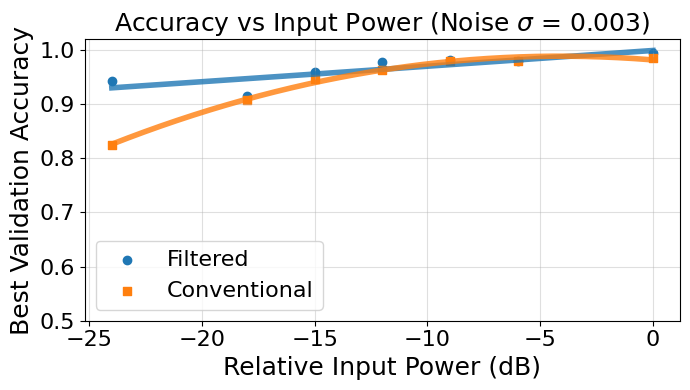

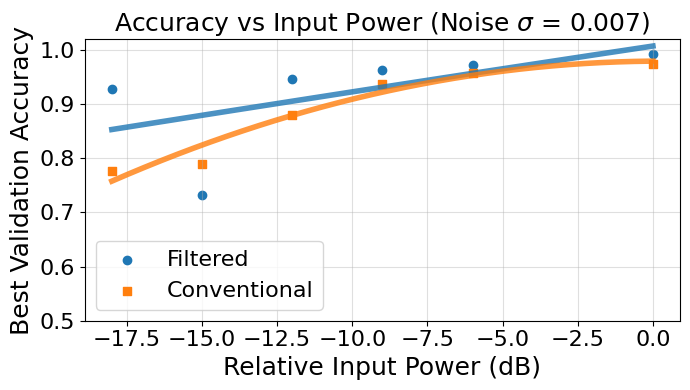

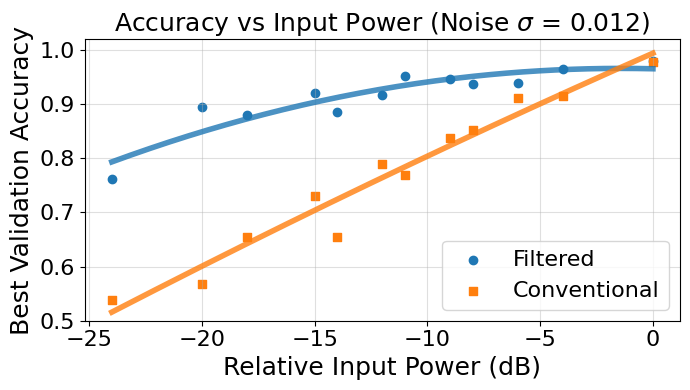

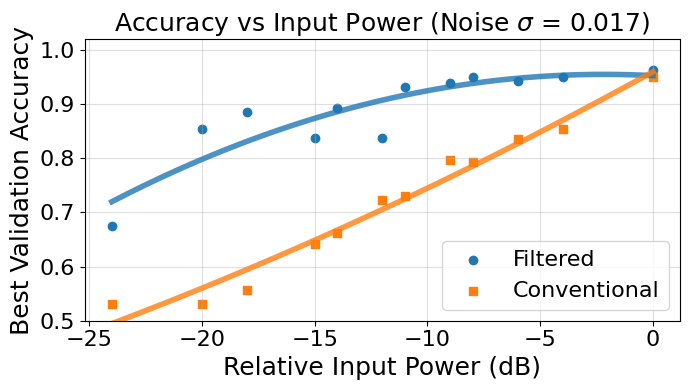

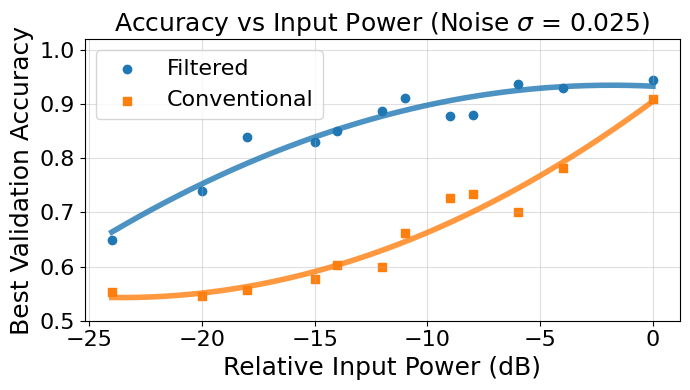

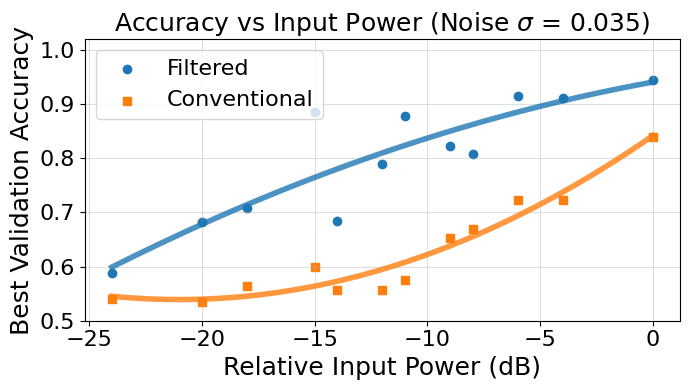

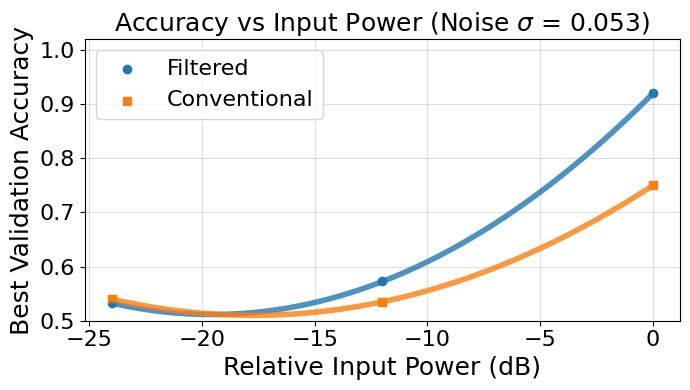

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools, os

# helper: sorted list of all σ that appear anywhere
def unique_noises(res):
    return sorted({σ for sub in res.values() for σ in sub})

# ------------- plotting loop ---------------------------------------
powers  = sorted(all_results)              # e.g. [-24,-18,-15,-12,-9,-6,0]
noises  = unique_noises(all_results)       # all σ present
colors  = {'Filtered':'C0', 'Conv':'C1'}   # consistent colours
markers = {'Filtered':'o',  'Conv':'s'}    # consistent markers

for noise_std in noises:
    # collect data for this σ
    p_vals, yF, yC = [], [], []
    for p in powers:
        if noise_std in all_results[p]:
            p_vals.append(p)
            yF.append(all_results[p][noise_std].get('E2E Filtered',      np.nan))
            yC.append(all_results[p][noise_std].get('E2E Conventional',  np.nan))
    if not p_vals:          # σ not present in any power – skip
        continue

    # make the plot
    plt.figure(figsize=(7,4))
    plt.scatter(p_vals, yF, color=colors['Filtered'],
                marker=markers['Filtered'], label='Filtered')
    plt.scatter(p_vals, yC, color=colors['Conv'],
                marker=markers['Conv'],     label='Conventional')

    # ------------ quadratic best‑fit --------------
    # choose polynomial degree
    deg = 2          # 1 for straight line, 2 for gentle curve
    # filtered
    coef_F = np.polyfit(p_vals, yF, deg=deg)
    p_lin  = np.linspace(min(p_vals), max(p_vals), 200)
    plt.plot(p_lin, np.polyval(coef_F, p_lin),
             color=colors['Filtered'], linestyle='-', linewidth=4,  alpha=0.8)
    # conventional
    coef_C = np.polyfit(p_vals, yC, deg=deg)
    plt.plot(p_lin, np.polyval(coef_C, p_lin),
             color=colors['Conv'],     linestyle='-', linewidth=4, alpha=0.8)

    plt.xlabel('Relative Input Power (dB)', fontsize=18)
    plt.ylabel('Best Validation Accuracy', fontsize=18)
    plt.title(f'Accuracy vs Input Power (Noise $\\sigma$ = {noise_std:.3f})', fontsize=18)
    plt.ylim(0.5, 1.02); plt.grid(True, ls='-', alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(fontsize=16)
    plt.tight_layout()
    # optional: save each figure
    # plt.savefig(f'accuracy_vs_power_sigma_{σ:.3f}.png', dpi=150)
    plt.show()


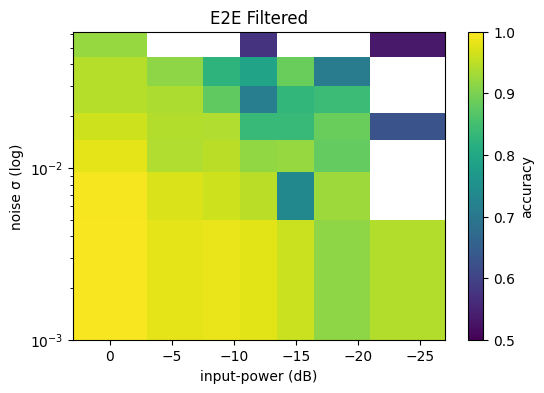

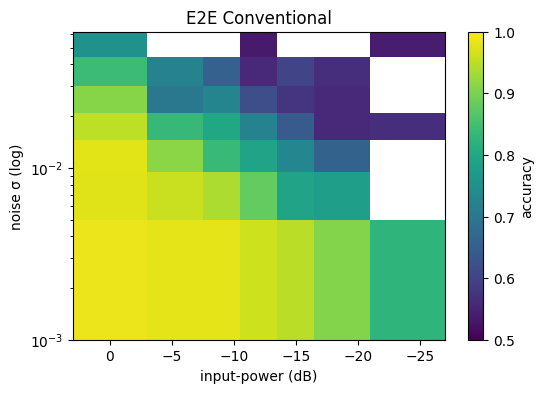

In [ ]:
def unique_noises(results):
    return sorted({σ for sub in results.values() for σ in sub})

def accuracy_heatmap(results, key='E2E Filtered'):
    P = sorted(results)
    S = unique_noises(results)
    Z = np.full((len(S),len(P)), np.nan)
    for i,p in enumerate(P):
        for j,σ in enumerate(S):
            if σ in results[p] and key in results[p][σ]:
                Z[j,i] = results[p][σ][key]

    plt.figure(figsize=(6,4))
    pcm = plt.pcolormesh(P, S, Z, vmin=0.5, vmax=1.0,
                         shading='nearest', cmap='viridis')
    plt.colorbar(pcm, label='accuracy')
    plt.yscale('log'); plt.gca().invert_xaxis()
    plt.xlabel('input‑power (dB)'); plt.ylabel('noise σ (log)')
    plt.title(key); plt.show()

accuracy_heatmap(all_results, 'E2E Filtered')
accuracy_heatmap(all_results, 'E2E Conventional')
